In [362]:
import pandas as pd
from pathlib import Path
from tnseq2.src.analysis import *
from tnseq2.src.method2_analysis import *
import numpy as np
from scipy.stats import ranksums
import matplotlib.pyplot as plt
import chart_studio
import chart_studio.tools as tls
import chart_studio.plotly as py
import plotly.express as px
%matplotlib inline
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
import dash_bio as dashbio

## Data Normalization

- Count data normalization is essential to get valid results from the analysis.
- I have looked at a number of different transformations, and suggest VST (implemented in DESeq2 package) as the most appropriate transformation for this data set.
- Here I compare VST transformation to rarefaction (which is not a good way to normalize data for this experiment, and produces unstable results, i.e. results vary depending on the rarefaction level) as well as the original analysis already presented. 


### Data Used:

- All experiments using library 10_2 are being analyzed together


### Filtering bottleneck samples:

- as before


In [2]:
root ="/Users/ansintsova/git_repos/nguyenb_tnseq/data/13_04_results"
results = "results"
counts = "counts"
control_file = Path(root)/'controls.txt'
dnaids = ['dnaid1315', 'dnaid1428', 'dnaid1429', 'dnaid2015', 'dnaid2016', 'dnaid2017', 'dnaid2018', 'dnaid2019',
         'dnaid2023', 'dnaid2024', 'dnaid2025', 'dnaid2026', 'dnaid2027', 'dnaid2028', 'dnaid2029' ]
cnt_df = load_files(dnaids, Path(root)/counts)
lib10_cnt = cnt_df[cnt_df.library == 'library_10_2'].copy()
lib10_cnt['sampleIDExp'] = lib10_cnt['sampleID'] + "_"+ lib10_cnt['dnaid'] + "_" + lib10_cnt['experiment']

annotation_df = cnt_df[['barcode', 'ShortName', 'locus_tag', 'phenotype', 'conc']].drop_duplicates()

control_file = Path(root)/'controls.txt'
corr_df, good_samples = calculate_correlation(lib10_cnt, control_file, for_each='sampleIDExp')
good_samples = list(good_samples)
good_samples.remove('unenriched_inoculum_d0_dnaid2017_TV4592A')
#good_samples

In [6]:
lib10_cnt

barcode     cnt  libcnt     sstart      sseqid sstrand  \
7749  AAAAAAACTGTAGTGCA  5233.0  1903.0  2051411.0  FQ312003.1    plus   
7750  AAAAAACGTCCGCGATG  2828.0  2152.0  3844829.0  FQ312003.1    plus   
7751  AAAAACATGCCACACTG  1684.0  2894.0  4014889.0  FQ312003.1    plus   
7752  AAAAACGCCGTTAAACT  2004.0  1078.0  1176550.0  FQ312003.1    plus   
7753  AAAAACTTTATACTTGA  2451.0  2353.0    36203.0  FQ312003.1    plus   
...                 ...     ...     ...        ...         ...     ...   
1024  GGACATTTGACCGGGTC     7.0     NaN        NaN         NaN     NaN   
1030  ATCTAAGGGTGCCCGAA     8.0     NaN        NaN         NaN     NaN   
1032  ATCTAAGGGTGCCCGAA     5.0     NaN        NaN         NaN     NaN   
1034  ATCTAAGGGTGCCCGAA   136.0     NaN        NaN         NaN     NaN   
1038  ATCTAAGGGTGCCCGAA     2.0     NaN        NaN         NaN     NaN   

     multimap          ShortName                locus_tag    sampleName  ...  \
7749    False        SL1344_1940              SL1344_1940  dnaid2017_65  ...   
7750    False               lpfD  SL1344_3602;pseudo=true  dnaid2017_65  ...   
7751    False  AAAAACATGCCACACTG                      NaN  dnaid2017_65  ...   
7752    False        SL1344_1068              SL1344_1068  dnaid2017_65  ...   
7753    False        SL1344_0033              SL1344_0033  dnaid2017_65  ...   
...       ...                ...                      ...           ...  ...   
1024      NaN                NaN                      NaN  dnaid2029_66  ...   
1030      NaN                NaN                      NaN  dnaid2029_23  ...   
1032      NaN                NaN                      NaN  dnaid2029_19  ...   
1034      NaN                NaN                      NaN   dnaid2029_8  ...   
1038      NaN                NaN                      NaN  dnaid2029_28  ...   

      experiment     mouse day    tissue      dnaid     sampleID    DN  \
7749     TV4592A     ad927  d1     feces  dnaid2017     ad927_d1   NaN   
7750     TV4592A     ad927  d1     feces  dnaid2017     ad927_d1   NaN   
7751     TV4592A     ad927  d1     feces  dnaid2017     ad927_d1   NaN   
7752     TV4592A     ad927  d1     feces  dnaid2017     ad927_d1   NaN   
7753     TV4592A     ad927  d1     feces  dnaid2017     ad927_d1   NaN   
...          ...       ...  ..       ...        ...          ...   ...   
1024     TV5585A     am727  d4     feces  dnaid2029     am727_d4  21.0   
1030     TV5585A     am728  d3     feces  dnaid2029     am728_d3  22.0   
1032     TV5585A     am727  d3     feces  dnaid2029     am727_d3  22.0   
1034     TV5585A  inoculum  d0  inoculum  dnaid2029  inoculum_d0  22.0   
1038     TV5585A     am732  d3     feces  dnaid2029     am732_d3  22.0   

     phenotype      conc                    sampleIDExp  
7749       NaN       NaN     ad927_d1_dnaid2017_TV4592A  
7750       NaN       NaN     ad927_d1_dnaid2017_TV4592A  
7751       NaN       NaN     ad927_d1_dnaid2017_TV4592A  
7752       NaN       NaN     ad927_d1_dnaid2017_TV4592A  
7753       NaN       NaN     ad927_d1_dnaid2017_TV4592A  
...        ...       ...                            ...  
1024      chey  0.000056     am727_d4_dnaid2029_TV5585A  
1030      chey  0.000019     am728_d3_dnaid2029_TV5585A  
1032      chey  0.000019     am727_d3_dnaid2029_TV5585A  
1034      chey  0.000019  inoculum_d0_dnaid2029_TV5585A  
1038      chey  0.000019     am732_d3_dnaid2029_TV5585A  

[171070 rows x 22 columns]

In [37]:
outdir = '/Users/ansintsova/git_repos/nguyenb_tnseq/data/01_06'

_, final = analyze_library(lib10_cnt, sample_id="sampleIDExp", 
                          good_samples=good_samples, 
                          dnaid='library10', experiment='2', 
                          control_file=control_file, cutoff=0.8, 
                          to_filter=1000, outdir=outdir)

Counter({'d1': 17, 'd2': 14, 'd3': 12, 'd4': 9})
Filtering Dataset
Running DESeq2
Calculating z-scores
  day  cntrl_FC  cntrl_FC_median  cntrl_sigma
0  d1  0.758317         0.775589     0.214664
1  d2  0.472019         0.504645     0.219805
2  d3  0.385722         0.485621     0.224578
3  d4  0.191070         0.201673     0.235340
Summarizing


## VST Transformation

In [334]:
import datetime as dt
dt.date.today().strftime("%Y-%m-%d")

'2021-06-03'

In [360]:
tvst = run_VST_transformation(lib10_cnt, 'lib10_tst', good_samples, '/Users/ansintsova/git_repos/nguyenb_tnseq/data/01_06',
                       sample_id='sampleIDExp')

Generating datasets for DESeq2
Running DESeq2 VST Transformation
Done


In [361]:
tvst.head()

Unnamed: 0  ad927_d1_dnaid2017_TV4592A  ad927_d2_dnaid2017_TV4592A  \
0  AAAAAAACTGTAGTGCA                   11.384368                   11.661206   
1  AAAAAACGTCCGCGATG                   10.528694                   10.998080   
2  AAAAACATGCCACACTG                    9.826515                    9.750115   
3  AAAAACGCCGTTAAACT                   10.059714                    9.915984   
4  AAAAACTTTATACTTGA                   10.332820                   10.529709   

   ad930_d1_dnaid2017_TV4592A  ad926_d2_dnaid2017_TV4592A  \
0                   11.231214                   11.389915   
1                   11.216625                   11.808558   
2                   11.686786                   11.854226   
3                    9.869767                   10.268243   
4                   11.131906                   11.767107   

   unenriched_inoculum_d0_dnaid2017_TV4592A  ad928_d2_dnaid2017_TV4592A  \
0                                 11.235467                   11.488686   
1                                 11.200468                   11.478477   
2                                 11.363182                   11.643595   
3                                 10.034380                   10.019151   
4                                 11.149174                   11.062042   

   ad926_d1_dnaid2017_TV4592A  ad928_d1_dnaid2017_TV4592A  \
0                   11.392132                   11.453710   
1                   11.313721                   11.342329   
2                   11.886294                   11.402589   
3                   10.202565                    9.765295   
4                   11.312462                   10.798674   

   ad930_d2_dnaid2017_TV4592A  ...  am729_d4_dnaid2029_TV5585A  \
0                   11.532341  ...                   10.903914   
1                   11.636338  ...                   10.744521   
2                   11.669584  ...                    8.670837   
3                    9.685096  ...                   10.154999   
4                   11.402898  ...                   11.345324   

   am727_d3_dnaid2029_TV5585A  inoculum_d0_dnaid2029_TV5585A  \
0                   11.612122                      11.540775   
1                   11.725083                      11.515359   
2                   11.823274                      11.753307   
3                    9.036476                      10.251323   
4                   12.091559                      11.505481   

   am730_d3_dnaid2029_TV5585A  am731_d3_dnaid2029_TV5585A  \
0                   13.609368                   10.816510   
1                    9.045337                   12.931119   
2                    8.208926                   11.890118   
3                    9.068815                    5.175039   
4                    8.983130                   12.754984   

   am732_d3_dnaid2029_TV5585A  am730_d4_dnaid2029_TV5585A  \
0                   15.811206                   13.897085   
1                   10.477042                    7.748507   
2                   12.182785                    9.835657   
3                    5.175039                   10.456858   
4                    7.636929                    7.798947   

   am728_d4_dnaid2029_TV5585A  am732_d4_dnaid2029_TV5585A  \
0                   10.031268                   14.491453   
1                   10.936670                   16.059710   
2                   11.225019                   12.640065   
3                   11.081494                    5.175039   
4                   14.074766                    5.862031   

   am727_d4_dnaid2029_TV5585A  
0                   12.218126  
1                   12.085457  
2                   11.910081  
3                    9.332265  
4                   12.331756  

[5 rows x 74 columns]

In [326]:
# sdf = lib10_cnt[['sampleID', 'mouse', 'day', 'tissue', 'dnaid', 'experiment', 'sampleIDExp']].set_index('sampleIDExp').drop_duplicates()
# edf = (lib10_cnt[['barcode', 'sampleIDExp', 'experiment', 'mouse', 'day', 'tissue', 'dnaid', 'cnt']].drop_duplicates()
#        .pivot(index='barcode', columns='sampleIDExp', values='cnt'))
# edf = edf[list(sdf.index)]
# edf = edf.fillna(0)
# sdf.to_csv(Path(root)/results/'30_04_lib10_sdf.csv')
# edf.to_csv(Path(root)/results/'30_04_lib10_edf.csv')
# Run DESeq2 script
vst = pd.read_csv(Path(root)/'results/30_14_lib10_vsd.csv').rename({'Unnamed: 0':'barcode'}, axis=1).set_index('barcode')
vst = vst.drop('unenriched_inoculum_d0_dnaid2017_TV4592A', axis=1)


In [327]:
vst.head()

ad927_d1_dnaid2017_TV4592A  ad927_d2_dnaid2017_TV4592A  \
barcode                                                                     
AAAAAAACTGTAGTGCA                   11.384368                   11.661206   
AAAAAACGTCCGCGATG                   10.528694                   10.998080   
AAAAACATGCCACACTG                    9.826515                    9.750115   
AAAAACGCCGTTAAACT                   10.059714                    9.915984   
AAAAACTTTATACTTGA                   10.332820                   10.529709   

                   ad930_d1_dnaid2017_TV4592A  ad926_d2_dnaid2017_TV4592A  \
barcode                                                                     
AAAAAAACTGTAGTGCA                   11.231214                   11.389915   
AAAAAACGTCCGCGATG                   11.216625                   11.808558   
AAAAACATGCCACACTG                   11.686786                   11.854226   
AAAAACGCCGTTAAACT                    9.869767                   10.268243   
AAAAACTTTATACTTGA                   11.131906                   11.767107   

                   ad928_d2_dnaid2017_TV4592A  ad926_d1_dnaid2017_TV4592A  \
barcode                                                                     
AAAAAAACTGTAGTGCA                   11.488686                   11.392132   
AAAAAACGTCCGCGATG                   11.478477                   11.313721   
AAAAACATGCCACACTG                   11.643595                   11.886294   
AAAAACGCCGTTAAACT                   10.019151                   10.202565   
AAAAACTTTATACTTGA                   11.062042                   11.312462   

                   ad928_d1_dnaid2017_TV4592A  ad930_d2_dnaid2017_TV4592A  \
barcode                                                                     
AAAAAAACTGTAGTGCA                   11.453710                   11.532341   
AAAAAACGTCCGCGATG                   11.342329                   11.636338   
AAAAACATGCCACACTG                   11.402589                   11.669584   
AAAAACGCCGTTAAACT                    9.765295                    9.685096   
AAAAACTTTATACTTGA                   10.798674                   11.402898   

                   inoculum_d0_dnaid2017_TV4592A  ad929_d1_dnaid2017_TV4592A  \
barcode                                                                        
AAAAAAACTGTAGTGCA                      11.056409                   11.359859   
AAAAAACGTCCGCGATG                      11.496602                   11.154588   
AAAAACATGCCACACTG                      11.704253                   11.633971   
AAAAACGCCGTTAAACT                       9.927735                    9.292851   
AAAAACTTTATACTTGA                      11.335167                   10.846106   

                   ...  am729_d4_dnaid2029_TV5585A  \
barcode            ...                               
AAAAAAACTGTAGTGCA  ...                   10.903914   
AAAAAACGTCCGCGATG  ...                   10.744521   
AAAAACATGCCACACTG  ...                    8.670837   
AAAAACGCCGTTAAACT  ...                   10.154999   
AAAAACTTTATACTTGA  ...                   11.345324   

                   am727_d3_dnaid2029_TV5585A  inoculum_d0_dnaid2029_TV5585A  \
barcode                                                                        
AAAAAAACTGTAGTGCA                   11.612122                      11.540775   
AAAAAACGTCCGCGATG                   11.725083                      11.515359   
AAAAACATGCCACACTG                   11.823274                      11.753307   
AAAAACGCCGTTAAACT                    9.036476                      10.251323   
AAAAACTTTATACTTGA                   12.091559                      11.505481   

                   am730_d3_dnaid2029_TV5585A  am731_d3_dnaid2029_TV5585A  \
barcode                                                                     
AAAAAAACTGTAGTGCA                   13.609368                   10.816510   
AAAAAACGTCCGCGATG                    9.045337                   12.931119   
AAAAACATGCCACACTG                    8.208926     

## Rarefaction

In [47]:
samples = [c.strip() for c in lib10_cnt.sampleIDExp.unique()]
samples.remove('am487_d1_dnaid2027_TV5563A')
samples.remove('unenriched_inoculum_d0_dnaid2017_TV4592A')
lib10_cnt_rare = lib10_cnt[lib10_cnt.sampleIDExp.isin(samples)]
edf_rare = (lib10_cnt_rare[['barcode', 'sampleIDExp', 'experiment', 'mouse', 'day', 'tissue', 'dnaid', 'cnt']].drop_duplicates()
       .pivot(index='barcode', columns='sampleIDExp', values='cnt'))
edf_rare = edf_rare.fillna(0)
edf_rare.to_csv(Path(root)/'results/03_05_lib10_rare_edf.csv')

## Rarefy with vegan in R

rare = (pd.read_csv(Path(root)/'results/05_05_lib10_rarefied_edf.csv')
        .set_index('Unnamed: 0').T)
rare.index.name = 'barcode'
rare = rare.drop('unenriched_inoculum_d0_dnaid2017_TV4592A', axis =1)


In [51]:
rarevsvst = px.scatter(x=rare.ad926_d1_dnaid2017_TV4592A, y=vst.ad926_d1_dnaid2017_TV4592A, 
          log_x=True, color_discrete_sequence= [px.colors.qualitative.Plotly[3]],
          labels= {'x': 'Rarefied Counts', 'y': 'VST Counts'},
          template = "simple_white")

rarevsvst.write_html("/Users/ansintsova/Documents/SushiLab/31-05-2021-Lab-Meeting/Rare_vs_VST.html")

In [54]:
import numpy as np
from skbio.stats.composition import clr

def clr_on_array_with_0(a):
    a = np.ma.masked_equal(a, 0)
    transformed = clr(a)
    transformed[transformed.mask] = a.fill_value
    transformed = transformed.data
    return transformed


def clr_on_array_with_pseudocount(a):
    transformed = clr(a+1)
    return transformed

clr_df= edf.copy().apply(clr_on_array_with_0)
clr2_df = edf.copy().apply(clr_on_array_with_pseudocount)

In [59]:
clrvsvst = px.scatter(x=clr2_df.ad926_d1_dnaid2017_TV4592A, y=vst.ad926_d1_dnaid2017_TV4592A, 
          color_discrete_sequence= [px.colors.qualitative.Plotly[3]],
          labels= {'x': 'CLR Norm Counts', 'y': 'VST Counts'},
          template = "simple_white")
clrvsvst.write_html("/Users/ansintsova/Documents/SushiLab/31-05-2021-Lab-Meeting/CLR_vs_VST.html")

## Load DESeq2 results

<AxesSubplot:>

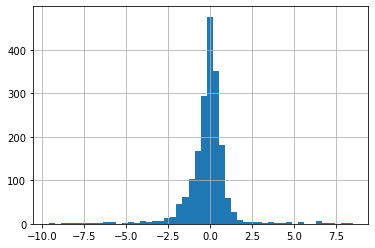

In [213]:
deseq1 = (pd.read_csv('/Users/ansintsova/git_repos/nguyenb_tnseq/data/13_04_results/results/d0_d1_deseq_results.csv')
          .rename({'Unnamed: 0': 'barcode'}, axis=1))

deseq1 = deseq1.merge(annotation_df, on='barcode')
deseqhits = deseq1[deseq1.padj < 0.05].ShortName.dropna().values
deseq1 = deseq1.groupby('ShortName').log2FoldChange.median().reset_index()
deseq1['fitness'] = 2**deseq1.log2FoldChange
deseq1.log2FoldChange.hist(bins=50)

## Analysis: 

- Calculate mean inoculum value for each barcode based on all inoculum (d0) samples (drop the uneriched sample).
- **For rarefied data, drop any barcodes with mean 0 in the inoculum**
- Caclulate fitness for each barcode, for rarefied data as counts on specific day/ counts in the inoculum, for VST data (which is on log2 scale) 2^counts on specific day/ 2^counts in teh inoculum 
- To get gene fitness, take median fitness of barcodes mapped to that gene
- WT fitness is the median fitness of all wt WITS barcodes
- Use Mann–Whitney U test (also called the Mann–Whitney–Wilcoxon (MWW), Wilcoxon rank-sum test) to test for significance of each gene 
- multi-test correction using Benjamini/Hochberg (non-negative)

- calculate CI at gene fitness/ wt fitness
- test for significane as before using ssaV_invG barcodes as controls
- calculate median/mean fitness/CI for each gene across all mice



In [213]:
import statsmodels
def gene_ranksums(gene_values, wt_values):
    return ranksums(gene_values, wt_values)[1]

def fdr_correction(pvals):
    return statsmodels.stats.multitest.multipletests(pvals, alpha=0.05, method='fdr_bh')[1]


def get_median_for_gene_on_a_day(df, annotation, day, grp_by='ShortName'):
    df = df.merge(annotation, on='barcode')
    samples = dict.fromkeys(([c for c in df.columns if day in c]), ['median'])
    day_median_value = df.groupby('ShortName').agg(samples)
    day_median_value.columns = [c[0] for c in day_median_value.columns]
    return day_median_value


def get_fitness(cnts, annotation, day, good_samples, hits=0.01, rare=False):
    # Calculate a mean value for all inoculum samples
    
    cnts['inoculum'] = cnts[[c for c in cnts.columns if 'd0' in c and 'unenriched' not in c]].mean(axis=1)
    cnts = cnts.dropna(subset=['inoculum']) # do I have any NAs?
    cnts = cnts[cnts.inoculum > 0]
    # Caclucalte fitness for each barcode
    if rare:
        fitness = cnts.apply(lambda x: x/cnts['inoculum']).reset_index()
    else:
        fitness = cnts.apply(lambda x: 2**x/2**cnts['inoculum']).reset_index()
    # Add gene annotation
    
    fitness = fitness.merge(annotation, on='barcode')
    # Calculate fitness for each gene
    # Drop controls for now
    gene_df = fitness[fitness.phenotype.isna()]
    # Calculate median value for each ShortName
    samples = dict.fromkeys(([c for c in good_samples if day in c]), ['median'])
    day_fitness = gene_df.groupby('ShortName').agg(samples)
    day_fitness.columns = [c[0] for c in day_fitness.columns]

    # Calculate median fitness for wt barcodes
    wt_fitness = fitness[fitness.phenotype == 'wt'][[c for c in good_samples if day in c]].median()
    
    # Calculate rnasksums test for wt vs each gene, multi-test correction using Benjamini/Hochberg (non-negative)
    pvals = day_fitness.apply(gene_ranksums,  axis=1, wt_values = wt_fitness)
    padj = fdr_correction(pvals.values)
    results = pd.DataFrame([pvals.values, padj], columns=pvals.index, index=['pval', 'padj']).T
    
    # Calculate CI
    day_ci = day_fitness.apply(lambda x: x/wt_fitness[x.name])
    ssa_fitness = fitness[fitness.phenotype == 'ssaV_invG'][[c for c in good_samples if day in c]].median()
    ssa_ci = ssa_fitness/wt_fitness
    
    pvals_ci = day_ci.apply(gene_ranksums,  axis=1, wt_values = ssa_ci)
    ci_res = pd.DataFrame([pvals_ci.values, fdr_correction(pvals_ci.values)], columns=pvals.index, index=['ci_pval', 'ci_padj']).T
    results = results.merge(ci_res, left_index=True, right_index=True)
    # Calculate median and mean fitness and median and mean CI
    
    results['median_fitness'] = day_fitness.median(axis=1)
    results['mean_fitness'] =  day_fitness.mean(axis=1)
    results['median_CI'] = day_ci.median(axis=1)
    results['mean_CI'] = day_ci.mean(axis=1)
    
    #day_ci = day_ci.merge(ci_res, left_index=True, right_index=True)
    controls = pd.concat([wt_fitness, ssa_fitness], axis=1)
    controls.columns = ['wt', 'ssaV_invG']
    controls['day'] = day.strip('_')
    ssa_ci = pd.DataFrame(ssa_ci).assign(day=day.strip("_"))
    ssa_ci.columns = ['CI', 'day']
    results['hits'] = results['padj'] < hits
    results['ci_hits'] = results['ci_padj'] < hits
    return fitness, day_fitness, day_ci, results, controls, ssa_ci

In [49]:
# VST

vst_cnt_d0 = get_median_for_gene_on_a_day(vst[good_samples], annotation_df, 'd0')
vst_inoculum_cnts = vst_cnt_d0.median(axis=1)
vst_inoculum_cnts.name = 'median_inoculum_value'

# Rare
rare_cnt_d0 = get_median_for_gene_on_a_day(rare[samples], annotation_df, 'd0')
rare_inoculum_cnts = rare_cnt_d0.median(axis=1)
rare_inoculum_cnts.name = 'median_inoculum_value'


In [329]:
days = ['_d0', '_d1', '_d2', '_d3', '_d4']
vst_cnt_genes = []
for day in days:
    print(day)
    df = get_median_for_gene_on_a_day(vst[good_samples], annotation_df, day)
    vst_cnt_genes.append(df)
fdf = pd.concat(vst_cnt_genes, axis=1)
fdf.sample(5)

_d0
_d1
_d2
_d3
_d4


inoculum_d0_dnaid2017_TV4592A  \
ShortName                                          
GTGGGGGATAAGGGCCA                       5.608677   
ACCTACTCGACAGTGGT                      11.887491   
moeB                                   10.019386   
melA                                   11.544093   
SL1344_2586                            11.160837   

                   inoculum_d0_dnaid2018_TV4592A  \
ShortName                                          
GTGGGGGATAAGGGCCA                       5.175039   
ACCTACTCGACAGTGGT                      11.868157   
moeB                                   10.017512   
melA                                   11.567312   
SL1344_2586                            11.127943   

                   inoculum_d0_dnaid2027_TV5563A  \
ShortName                                          
GTGGGGGATAAGGGCCA                       5.175039   
ACCTACTCGACAGTGGT                      12.044318   
moeB                                   10.268053   
melA                                   11.454178   
SL1344_2586                            11.574275   

                   inoculum_d0_dnaid2028_TV5585A  \
ShortName                                          
GTGGGGGATAAGGGCCA                       5.175039   
ACCTACTCGACAGTGGT                      11.935125   
moeB                                   10.388112   
melA                                   11.559505   
SL1344_2586                            11.402038   

                   inoculum_d0_dnaid2029_TV5585A  ad926_d1_dnaid2017_TV4592A  \
ShortName                                                                      
GTGGGGGATAAGGGCCA                       5.175039                    5.737074   
ACCTACTCGACAGTGGT                      11.934233                   11.305514   
moeB                                   10.393711                    8.679512   
melA                                   11.550639                   11.515489   
SL1344_2586                            11.404522                   11.267666   

                   ad927_d1_dnaid2017_TV4592A  ad928_d1_dnaid2017_TV4592A  \
ShortName                                                                   
GTGGGGGATAAGGGCCA                    5.175039                    5.836942   
ACCTACTCGACAGTGGT                   12.478756                   12.152746   
moeB                                 8.497660                    6.942013   
melA                                10.935300                   11.657303   
SL1344_2586                         10.904939                   10.959619   

                   ad929_d1_dnaid2017_TV4592A  ad930_d1_dnaid2017_TV4592A  \
ShortName                                                                   
GTGGGGGATAAGGGCCA                    6.198595                    5.598486   
ACCTACTCGACAGTGGT                   12.111921                   11.649056   
moeB                                 7.907381                    8.215047   
melA                                11.473704                   11.448410   
SL1344_2586                         10.915656                   10.953409   

                   ...  am732_d3_dnaid2029_TV5585A  \
ShortName          ...                               
GTGGGGGATAAGGGCCA  ...                    5.175039   
ACCTACTCGACAGTGGT  ...                   15.651261   
moeB               ...                    5.175039   
melA               ...                   12.007872   
SL1344_2586        ...                    6.689321   

                   ad926_d4_dnaid2018_TV4592A  ad927_d4_dnaid2018_TV4592A  \
ShortName                                                                   
GTGGGGGATAAGGGCCA                    5.175039                    5.175039   
ACCTACTCGACAGTGGT                   11.615328                   12.691863   
moeB                                 6.112110                    6.195546   
melA                                11.879415                   12.023822   
SL1344_2586                         10.749346                   11.039891   


In [18]:
fdf.to_csv(Path(root)/"results/gene_counts_vst_transform.csv")

## Day 1

In [215]:
# VST
fitness, vst_fit_d1, vst_ci_d1, vst_d1_results, vst_controls_d1, vst_ssa_ci_d1 = get_fitness(vst, annotation_df, 'd1', good_samples=good_samples,  hits=0.05)

#vst_fit_d1 = vst_fit_d1.merge(2**vst_inoculum_cnts, on='ShortName')

# RARE

f, rare_fit_d1, rare_ci_d1, rare_day1_results, rare_controls_d1, rare_ssa_ci_d1 = get_fitness(rare, annotation_df, 'd1', good_samples=samples, rare=True,  hits=0.05)

rare_fit_d1 = rare_fit_d1.merge(rare_inoculum_cnts, on='ShortName')

d1_cntrl = vst_controls_d1.merge(rare_controls_d1, left_index=True, right_index=True, on='day')
d1_cntrl.columns = ['vst_wt', 'vst_ssaV', 'day', 'rare_wt', 'rare_ssaV', ]
d1_cntrl.melt(id_vars='day')

#px.box(d1_cntrl.melt(), x="variable", y="value",  color='variable')

day   variable     value
0   d1     vst_wt  0.936862
1   d1     vst_wt  0.624402
2   d1     vst_wt  1.139436
3   d1     vst_wt  1.050117
4   d1     vst_wt  0.969890
..  ..        ...       ...
59  d1  rare_ssaV  0.960000
60  d1  rare_ssaV  0.940058
61  d1  rare_ssaV  0.024814
62  d1  rare_ssaV  0.064267
63  d1  rare_ssaV  0.580409

[64 rows x 3 columns]

In [217]:
fitness.head()

barcode  ad927_d1_dnaid2017_TV4592A  ad927_d2_dnaid2017_TV4592A  \
0  AAAAAAACTGTAGTGCA                    1.006818                    1.219798   
1  AAAAAACGTCCGCGATG                    0.500964                    0.693594   
2  AAAAACATGCCACACTG                    0.268403                    0.254559   
3  AAAAACGCCGTTAAACT                    0.978821                    0.886005   
4  AAAAACTTTATACTTGA                    0.452990                    0.519228   

   ad930_d1_dnaid2017_TV4592A  ad926_d2_dnaid2017_TV4592A  \
0                    0.905414                    1.010697   
1                    0.807038                    1.216421   
2                    0.974508                    1.094435   
3                    0.858071                    1.131037   
4                    0.788202                    1.224199   

   ad928_d2_dnaid2017_TV4592A  ad926_d1_dnaid2017_TV4592A  \
0                    1.082315                    1.012251   
1                    0.967653                    0.863223   
2                    0.945766                    1.119034   
3                    0.951683                    1.080700   
4                    0.750942                    0.893286   

   ad928_d1_dnaid2017_TV4592A  ad930_d2_dnaid2017_TV4592A  \
0                    1.056392                    1.115566   
1                    0.880511                    1.079544   
2                    0.800264                    0.962957   
3                    0.798131                    0.754974   
4                    0.625641                    0.951075   

   inoculum_d0_dnaid2017_TV4592A  ...  am732_d3_dnaid2029_TV5585A  \
0                       0.802095  ...                   21.655191   
1                       0.979886  ...                    0.483345   
2                       0.986378  ...                    1.374345   
3                       0.893251  ...                    0.033134   
4                       0.907455  ...                    0.069911   

   am730_d4_dnaid2029_TV5585A  am728_d4_dnaid2029_TV5585A  \
0                    5.745849                    0.394119   
1                    0.072927                    0.664690   
2                    0.270110                    0.707587   
3                    1.289007                    1.987420   
4                    0.078220                    6.060757   

   am732_d4_dnaid2029_TV5585A  am727_d4_dnaid2029_TV5585A  inoculum  \
0                    8.675148                    1.794475       1.0   
1                   23.163710                    1.473800       1.0   
2                    1.886909                    1.137637       1.0   
3                    0.033134                    0.591179       1.0   
4                    0.020429                    1.810626       1.0   

           ShortName                locus_tag  phenotype  conc  
0        SL1344_1940              SL1344_1940        NaN   NaN  
1               lpfD  SL1344_3602;pseudo=true        NaN   NaN  
2  AAAAACATGCCACACTG                      NaN        NaN   NaN  
3        SL1344_1068              SL1344_1068        NaN   NaN  
4        SL1344_0033              SL1344_0033        NaN   NaN  

[5 rows x 78 columns]

In [226]:
?pd.melt

In [295]:
def get_control_df(fitness, phenotype='wt'):
    wt = fitness[fitness.phenotype == phenotype].dropna(axis=1).drop(['inoculum'], axis=1)
    wt = wt.melt(id_vars=['barcode', 'phenotype', 'conc'], var_name='sampleExpID', value_name='fitness')
    new = wt.sampleExpID.str.split("_", expand=True)
    new.columns = ['mouse', 'day', 'dnaid', 'experiment']
    wt = wt.merge(new, left_index=True, right_index=True)
    return wt

In [235]:
wt = fitness[fitness.phenotype == 'wt'].dropna(axis=1).drop(['inoculum'], axis=1)
wt = wt.melt(id_vars=['barcode', 'phenotype', 'conc'], var_name='sampleExpID', value_name='fitness')
new = wt.sampleExpID.str.split("_", expand=True)
new.columns = ['mouse', 'day', 'dnaid', 'experiment']
wt = wt.merge(new, left_index=True, right_index=True)
wt_d1 = wt[wt.day == 'd1']


barcode phenotype      conc                 sampleExpID  \
0    AACAACACGGTAAGCAA        wt  0.000019  ad927_d1_dnaid2017_TV4592A   
1    ACAGAGCTCGGGAGTCT        wt  0.000167  ad927_d1_dnaid2017_TV4592A   
2    ACTACAAGACTGGTTAA        wt  0.000056  ad927_d1_dnaid2017_TV4592A   
3    AGAATGACCCGGAGGCT        wt  0.001500  ad927_d1_dnaid2017_TV4592A   
4    AGATGCATGACTAGCTA        wt  0.000019  ad927_d1_dnaid2017_TV4592A   
..                 ...       ...       ...                         ...   
865  GTGTATAGCAGGAACCC        wt  0.000167  am732_d1_dnaid2028_TV5585A   
866  TAAGTCCGGGCTAAGTC        wt  0.000056  am732_d1_dnaid2028_TV5585A   
867  TACCCAGAGCACACTCA        wt  0.001500  am732_d1_dnaid2028_TV5585A   
868  TATAACACCCCCGATTC        wt  0.001500  am732_d1_dnaid2028_TV5585A   
869  TCTCACGCAGCGTTTCG        wt  0.000019  am732_d1_dnaid2028_TV5585A   

       fitness  mouse day      dnaid experiment  
0     0.276852  ad927  d1  dnaid2017    TV4592A  
1     1.439026  ad927  d1  dnaid2017    TV4592A  
2     0.153214  ad927  d1  dnaid2017    TV4592A  
3     1.252950  ad927  d1  dnaid2017    TV4592A  
4     0.237015  ad927  d1  dnaid2017    TV4592A  
..         ...    ...  ..        ...        ...  
865   3.389577  am732  d1  dnaid2028    TV5585A  
866   2.363499  am732  d1  dnaid2028    TV5585A  
867   8.070014  am732  d1  dnaid2028    TV5585A  
868  30.032922  am732  d1  dnaid2028    TV5585A  
869   2.184900  am732  d1  dnaid2028    TV5585A  

[255 rows x 9 columns]

In [297]:
hyb = get_control_df(fitness, phenotype='hyb')
hyb

barcode phenotype      conc                 sampleExpID  \
0    AAAATGCGCACTACGAA       hyb  0.000167  ad927_d1_dnaid2017_TV4592A   
1    AACCATGATACAACAAT       hyb  0.000056  ad927_d1_dnaid2017_TV4592A   
2    AGACAGGTAGAGGCCAT       hyb  0.000019  ad927_d1_dnaid2017_TV4592A   
3    GGCGTGACTGCAAGGGC       hyb  0.000500  ad927_d1_dnaid2017_TV4592A   
4    TTCGTACACCATGAGGT       hyb  0.001500  ad927_d1_dnaid2017_TV4592A   
..                 ...       ...       ...                         ...   
355  AAAATGCGCACTACGAA       hyb  0.000167  am727_d4_dnaid2029_TV5585A   
356  AACCATGATACAACAAT       hyb  0.000056  am727_d4_dnaid2029_TV5585A   
357  AGACAGGTAGAGGCCAT       hyb  0.000019  am727_d4_dnaid2029_TV5585A   
358  GGCGTGACTGCAAGGGC       hyb  0.000500  am727_d4_dnaid2029_TV5585A   
359  TTCGTACACCATGAGGT       hyb  0.001500  am727_d4_dnaid2029_TV5585A   

      fitness  mouse day      dnaid experiment  
0    0.047246  ad927  d1  dnaid2017    TV4592A  
1    0.155335  ad927  d1  dnaid2017    TV4592A  
2    0.290722  ad927  d1  dnaid2017    TV4592A  
3    0.033098  ad927  d1  dnaid2017    TV4592A  
4    0.006042  ad927  d1  dnaid2017    TV4592A  
..        ...    ...  ..        ...        ...  
355  0.196018  am727  d4  dnaid2029    TV5585A  
356  0.155335  am727  d4  dnaid2029    TV5585A  
357  0.290722  am727  d4  dnaid2029    TV5585A  
358  0.038367  am727  d4  dnaid2029    TV5585A  
359  0.498896  am727  d4  dnaid2029    TV5585A  

[360 rows x 9 columns]

In [301]:
px.box(wt_d1, x='mouse', y=np.log2(wt_d1['fitness']), color= 'conc', hover_data=['conc'])

In [321]:
wt

barcode phenotype      conc                 sampleExpID  \
0     AACAACACGGTAAGCAA        wt  0.000019  ad927_d1_dnaid2017_TV4592A   
1     ACAGAGCTCGGGAGTCT        wt  0.000167  ad927_d1_dnaid2017_TV4592A   
2     ACTACAAGACTGGTTAA        wt  0.000056  ad927_d1_dnaid2017_TV4592A   
3     AGAATGACCCGGAGGCT        wt  0.001500  ad927_d1_dnaid2017_TV4592A   
4     AGATGCATGACTAGCTA        wt  0.000019  ad927_d1_dnaid2017_TV4592A   
...                 ...       ...       ...                         ...   
1075  GTGTATAGCAGGAACCC        wt  0.000167  am727_d4_dnaid2029_TV5585A   
1076  TAAGTCCGGGCTAAGTC        wt  0.000056  am727_d4_dnaid2029_TV5585A   
1077  TACCCAGAGCACACTCA        wt  0.001500  am727_d4_dnaid2029_TV5585A   
1078  TATAACACCCCCGATTC        wt  0.001500  am727_d4_dnaid2029_TV5585A   
1079  TCTCACGCAGCGTTTCG        wt  0.000019  am727_d4_dnaid2029_TV5585A   

       fitness  mouse day      dnaid experiment  
0     0.276852  ad927  d1  dnaid2017    TV4592A  
1     1.439026  ad927  d1  dnaid2017    TV4592A  
2     0.153214  ad927  d1  dnaid2017    TV4592A  
3     1.252950  ad927  d1  dnaid2017    TV4592A  
4     0.237015  ad927  d1  dnaid2017    TV4592A  
...        ...    ...  ..        ...        ...  
1075  0.622485  am727  d4  dnaid2029    TV5585A  
1076  1.809642  am727  d4  dnaid2029    TV5585A  
1077  4.420666  am727  d4  dnaid2029    TV5585A  
1078  1.274228  am727  d4  dnaid2029    TV5585A  
1079  0.264125  am727  d4  dnaid2029    TV5585A  

[1080 rows x 9 columns]

In [324]:
px.box(wt, x='day', y=np.log2(wt['fitness']), color= 'mouse', hover_data=['conc'])

In [305]:
hyb_d1 = hyb[hyb.day == 'd1']

In [307]:
hyb_d1

barcode phenotype      conc                 sampleExpID  \
0    AAAATGCGCACTACGAA       hyb  0.000167  ad927_d1_dnaid2017_TV4592A   
1    AACCATGATACAACAAT       hyb  0.000056  ad927_d1_dnaid2017_TV4592A   
2    AGACAGGTAGAGGCCAT       hyb  0.000019  ad927_d1_dnaid2017_TV4592A   
3    GGCGTGACTGCAAGGGC       hyb  0.000500  ad927_d1_dnaid2017_TV4592A   
4    TTCGTACACCATGAGGT       hyb  0.001500  ad927_d1_dnaid2017_TV4592A   
..                 ...       ...       ...                         ...   
285  AAAATGCGCACTACGAA       hyb  0.000167  am732_d1_dnaid2028_TV5585A   
286  AACCATGATACAACAAT       hyb  0.000056  am732_d1_dnaid2028_TV5585A   
287  AGACAGGTAGAGGCCAT       hyb  0.000019  am732_d1_dnaid2028_TV5585A   
288  GGCGTGACTGCAAGGGC       hyb  0.000500  am732_d1_dnaid2028_TV5585A   
289  TTCGTACACCATGAGGT       hyb  0.001500  am732_d1_dnaid2028_TV5585A   

      fitness  mouse day      dnaid experiment  
0    0.047246  ad927  d1  dnaid2017    TV4592A  
1    0.155335  ad927  d1  dnaid2017    TV4592A  
2    0.290722  ad927  d1  dnaid2017    TV4592A  
3    0.033098  ad927  d1  dnaid2017    TV4592A  
4    0.006042  ad927  d1  dnaid2017    TV4592A  
..        ...    ...  ..        ...        ...  
285  0.495592  am732  d1  dnaid2028    TV5585A  
286  3.310980  am732  d1  dnaid2028    TV5585A  
287  0.290722  am732  d1  dnaid2028    TV5585A  
288  3.015986  am732  d1  dnaid2028    TV5585A  
289  0.729405  am732  d1  dnaid2028    TV5585A  

[85 rows x 9 columns]

In [319]:
px.box(hyb, x='day', y=np.log2(hyb['fitness']),  color='mouse', hover_data=['mouse'])

In [256]:
lib10_wt = lib10_cnt[lib10_cnt.phenotype == 'wt'][['barcode','cnt', 'conc', 'mouse', 'day', 'experiment']]

In [249]:
lib10_cnt.groupby('sampleIDExp').cnt.sum().sort_values()

sampleIDExp
am487_d1_dnaid2027_TV5563A         241632.0
am486_d1_dnaid2027_TV5563A        2068541.0
am485_d1_dnaid2027_TV5563A        4104891.0
inoculum_d0_dnaid2018_TV4592A     4677199.0
am732_d1_dnaid2028_TV5585A        5347488.0
                                    ...    
am727_d1_dnaid2028_TV5585A       11227687.0
am485_d3_dnaid2027_TV5563A       11356980.0
am729_d1_dnaid2028_TV5585A       11357836.0
am484_d2_dnaid2027_TV5563A       11983871.0
am731_d4_dnaid2029_TV5585A       12313797.0
Name: cnt, Length: 73, dtype: float64

In [251]:
wt

barcode phenotype      conc                 sampleExpID  \
0     AACAACACGGTAAGCAA        wt  0.000019  ad927_d1_dnaid2017_TV4592A   
1     ACAGAGCTCGGGAGTCT        wt  0.000167  ad927_d1_dnaid2017_TV4592A   
2     ACTACAAGACTGGTTAA        wt  0.000056  ad927_d1_dnaid2017_TV4592A   
3     AGAATGACCCGGAGGCT        wt  0.001500  ad927_d1_dnaid2017_TV4592A   
4     AGATGCATGACTAGCTA        wt  0.000019  ad927_d1_dnaid2017_TV4592A   
...                 ...       ...       ...                         ...   
1075  GTGTATAGCAGGAACCC        wt  0.000167  am727_d4_dnaid2029_TV5585A   
1076  TAAGTCCGGGCTAAGTC        wt  0.000056  am727_d4_dnaid2029_TV5585A   
1077  TACCCAGAGCACACTCA        wt  0.001500  am727_d4_dnaid2029_TV5585A   
1078  TATAACACCCCCGATTC        wt  0.001500  am727_d4_dnaid2029_TV5585A   
1079  TCTCACGCAGCGTTTCG        wt  0.000019  am727_d4_dnaid2029_TV5585A   

       fitness  mouse day      dnaid experiment  
0     0.276852  ad927  d1  dnaid2017    TV4592A  
1     1.439026  ad927  d1  dnaid2017    TV4592A  
2     0.153214  ad927  d1  dnaid2017    TV4592A  
3     1.252950  ad927  d1  dnaid2017    TV4592A  
4     0.237015  ad927  d1  dnaid2017    TV4592A  
...        ...    ...  ..        ...        ...  
1075  0.622485  am727  d4  dnaid2029    TV5585A  
1076  1.809642  am727  d4  dnaid2029    TV5585A  
1077  4.420666  am727  d4  dnaid2029    TV5585A  
1078  1.274228  am727  d4  dnaid2029    TV5585A  
1079  0.264125  am727  d4  dnaid2029    TV5585A  

[1080 rows x 9 columns]

In [250]:
px.strip(wt[wt.day == 'd1'], x='mouse', y='fitness', color= 'conc', hover_data=['conc'])

In [ ]:
px.strip(wt[wt.day == 'd1'], x='mouse', y='fitness', color= 'conc', hover_data=['conc'])

In [291]:
test = vst[[c for c in vst if 'am732_d1' in c]].reset_index()
test.head()

barcode  am732_d1_dnaid2028_TV5585A
0  AAAAAAACTGTAGTGCA                   14.910228
1  AAAAAACGTCCGCGATG                    7.152498
2  AAAAACATGCCACACTG                   15.424652
3  AAAAACGCCGTTAAACT                    6.917041
4  AAAAACTTTATACTTGA                    8.286526

In [265]:
lib10_wt[(lib10_wt.experiment == 'TV5585A') & (lib10_wt.day == 'd0')].sort_values('conc')

barcode      cnt      conc     mouse day experiment
622  TCTCACGCAGCGTTTCG    165.0  0.000019  inoculum  d0    TV5585A
373  AACAACACGGTAAGCAA    163.0  0.000019  inoculum  d0    TV5585A
178  AGATGCATGACTAGCTA    192.0  0.000019  inoculum  d0    TV5585A
413  AACAACACGGTAAGCAA    153.0  0.000019  inoculum  d0    TV5585A
558  TCTCACGCAGCGTTTCG    186.0  0.000019  inoculum  d0    TV5585A
196  AGATGCATGACTAGCTA    181.0  0.000019  inoculum  d0    TV5585A
529  CCGACGACTGATTGTCC    561.0  0.000056  inoculum  d0    TV5585A
371  TAAGTCCGGGCTAAGTC   1443.0  0.000056  inoculum  d0    TV5585A
160  ACTACAAGACTGGTTAA    467.0  0.000056  inoculum  d0    TV5585A
145  ACTACAAGACTGGTTAA    529.0  0.000056  inoculum  d0    TV5585A
339  TAAGTCCGGGCTAAGTC   1473.0  0.000056  inoculum  d0    TV5585A
583  CCGACGACTGATTGTCC    458.0  0.000056  inoculum  d0    TV5585A
297  AGTCATCGATGCTATAT   1573.0  0.000167  inoculum  d0    TV5585A
117  ACAGAGCTCGGGAGTCT   1197.0  0.000167  inoculum  d0    TV5585A
106  ACAGAGCTCGGGAGTCT   1496.0  0.000167  inoculum  d0    TV5585A
493  GTGTATAGCAGGAACCC    507.0  0.000167  inoculum  d0    TV5585A
326  AGTCATCGATGCTATAT   1339.0  0.000167  inoculum  d0    TV5585A
544  GTGTATAGCAGGAACCC    449.0  0.000167  inoculum  d0    TV5585A
451  CTACGACAGGGACTTAA   4686.0  0.000500  inoculum  d0    TV5585A
64   ATCCGCGTCACCGAAAA   4270.0  0.000500  inoculum  d0    TV5585A
500  CTACGACAGGGACTTAA   4084.0  0.000500  inoculum  d0    TV5585A
255  AGGAAGGCGACGAAATC   4222.0  0.000500  inoculum  d0    TV5585A
281  AGGAAGGCGACGAAATC   3692.0  0.000500  inoculum  d0    TV5585A
72   ATCCGCGTCACCGAAAA   3793.0  0.000500  inoculum  d0    TV5585A
409  TATAACACCCCCGATTC  13368.0  0.001500  inoculum  d0    TV5585A
236  AGAATGACCCGGAGGCT  12372.0  0.001500  inoculum  d0    TV5585A
22   TACCCAGAGCACACTCA  15680.0  0.001500  inoculum  d0    TV5585A
455  TATAACACCCCCGATTC  11941.0  0.001500  inoculum  d0    TV5585A
213  AGAATGACCCGGAGGCT  14203.0  0.001500  inoculum  d0    TV5585A
27   TACCCAGAGCACACTCA  13710.0  0.001500  inoculum  d0    TV5585A

In [292]:
t2  = lib10_wt[(lib10_wt.mouse == 'am732') & (lib10_wt.day == 'd1')].sort_values('conc').merge(test, how='left', on='barcode' )

In [293]:
t2

barcode      cnt      conc  mouse day experiment  \
0   AGATGCATGACTAGCTA     55.0  0.000019  am732  d1    TV5585A   
1   AACAACACGGTAAGCAA     61.0  0.000019  am732  d1    TV5585A   
2   TCTCACGCAGCGTTTCG     35.0  0.000019  am732  d1    TV5585A   
3   ACTACAAGACTGGTTAA     84.0  0.000056  am732  d1    TV5585A   
4   TAAGTCCGGGCTAAGTC    257.0  0.000056  am732  d1    TV5585A   
5   CCGACGACTGATTGTCC     69.0  0.000056  am732  d1    TV5585A   
6   ACAGAGCTCGGGAGTCT    389.0  0.000167  am732  d1    TV5585A   
7   AGTCATCGATGCTATAT    378.0  0.000167  am732  d1    TV5585A   
8   GTGTATAGCAGGAACCC    147.0  0.000167  am732  d1    TV5585A   
9   ATCCGCGTCACCGAAAA   6570.0  0.000500  am732  d1    TV5585A   
10  AGGAAGGCGACGAAATC    656.0  0.000500  am732  d1    TV5585A   
11  CTACGACAGGGACTTAA   3230.0  0.000500  am732  d1    TV5585A   
12  TACCCAGAGCACACTCA   7995.0  0.001500  am732  d1    TV5585A   
13  AGAATGACCCGGAGGCT   5137.0  0.001500  am732  d1    TV5585A   
14  TATAACACCCCCGATTC  25172.0  0.001500  am732  d1    TV5585A   

    am732_d1_dnaid2028_TV5585A  
0                     8.755514  
1                     8.882757  
2                     8.223315  
3                     9.286540  
4                    10.787488  
5                     9.036475  
6                    11.365678  
7                    11.325427  
8                    10.023856  
9                    15.406354  
10                   12.103611  
11                   14.384472  
12                   15.689131  
13                   15.052055  
14                   17.342435

In [294]:
px.scatter(t2, x=np.log2(t2['conc']), y='am732_d1_dnaid2028_TV5585A', trendline='ols', )

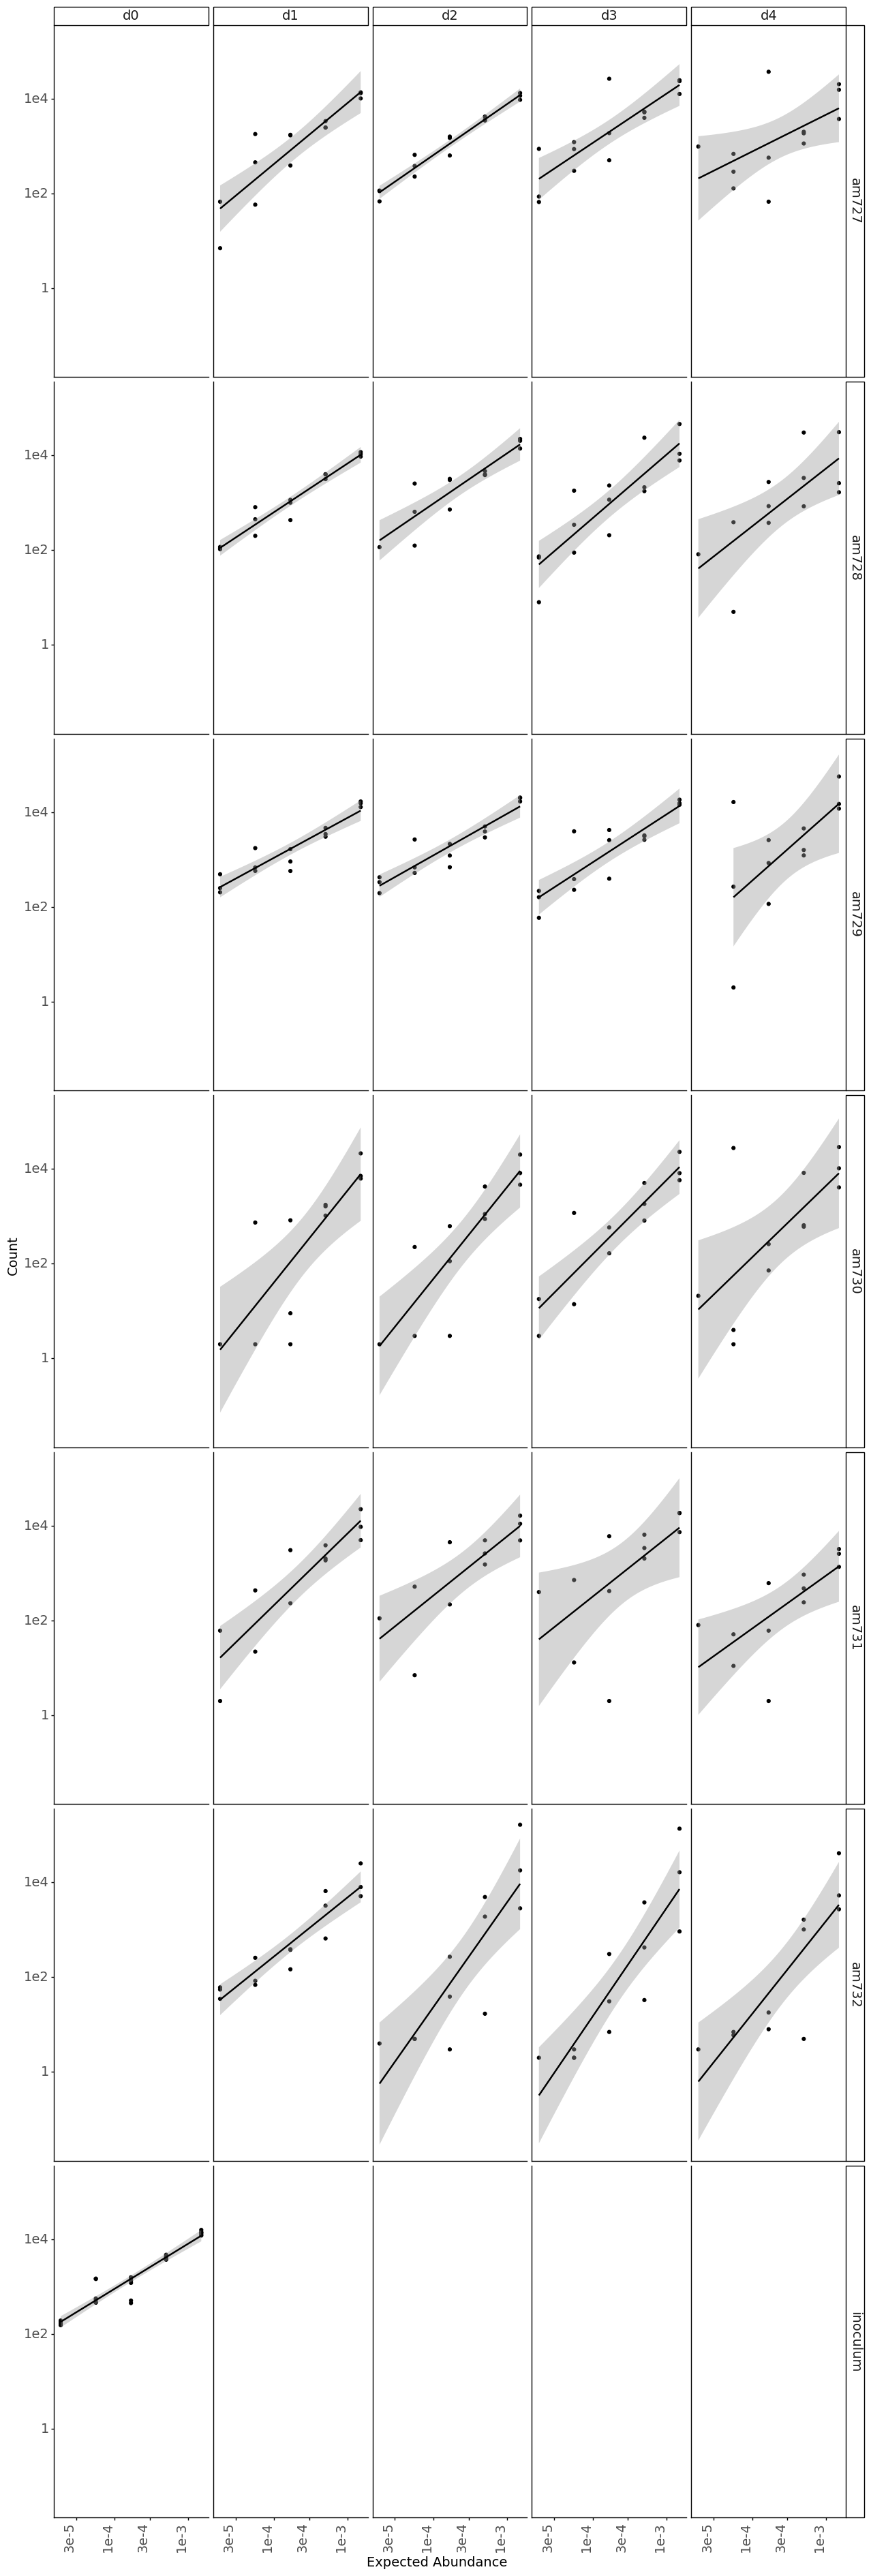

<ggplot: (-9223363264055592686)>

In [257]:
data = lib10_wt[lib10_wt.experiment =='TV5585A']
x = lib10_wt.day.nunique()
y = lib10_wt.mouse.nunique()
p9.options.figure_size = (x*3, y*2.5)
g = (p9.ggplot(data, p9.aes(x='conc', y='cnt'))
  + p9.geom_point()
  + p9.geom_smooth(method="lm")
  + p9.theme_classic()
  + p9.theme(text=p9.element_text(size=14),
             axis_text_x=p9.element_text(rotation=90, hjust=1))
    #+ p9.geom_text(p9.aes(label='Rlab', x=0.0001, y=.1))
  + p9.ylab("Count")
  + p9.xlab("Expected Abundance")
  + p9.scale_y_log10()
  + p9.scale_x_log10()
  + p9.facet_grid('mouse~day'))
g

In [53]:
final

locus  num_barcodes       library            barcode  \
gene                                                                            
AAAAACATGCCACACTG          NaN           1.0  library_10_2  AAAAACATGCCACACTG   
AAAACTTCATGTACAGA          NaN           1.0  library_10_2  AAAACTTCATGTACAGA   
AAACGGCCGAGTTCGAG          NaN           1.0  library_10_2  AAACGGCCGAGTTCGAG   
AAACGTCCCCACACGGG          NaN           1.0  library_10_2  AAACGTCCCCACACGGG   
AAACTCGACACTGGACA          NaN           1.0  library_10_2  AAACTCGACACTGGACA   
...                        ...           ...           ...                ...   
ysaA               SL1344_3631           1.0  library_10_2  TCTAGTGCCCATGTGCG   
ytfF               SL1344_4333           1.0  library_10_2  ACAGTCACCCGGTAGTA   
ytfG               SL1344_4334           1.0  library_10_2  TGTCTATCAGCTCATAG   
ytfJ               SL1344_4338           1.0  library_10_2  CGTGGGAAGGTACTAAG   
ytfM               SL1344_4342           1.0  library_10_2  AAACGGCCAACAACTGT   

                      sstart      sseqid  d1_num_samples  d1_fitness_mean  \
gene                                                                        
AAAAACATGCCACACTG  4014889.0  FQ312003.1            17.0         0.801205   
AAAACTTCATGTACAGA  3434671.0  FQ312003.1            17.0         1.025133   
AAACGGCCGAGTTCGAG  2374468.0  FQ312003.1            17.0        -0.319444   
AAACGTCCCCACACGGG  4675280.0  FQ312003.1            17.0         0.492743   
AAACTCGACACTGGACA        NaN         NaN            17.0         1.059957   
...                      ...         ...             ...              ...   
ysaA               3875663.0  FQ312003.1            17.0         0.559329   
ytfF               4658157.0  FQ312003.1            17.0         0.157595   
ytfG               4658824.0  FQ312003.1            17.0         0.149174   
ytfJ               4663456.0  FQ312003.1            17.0         0.745651   
ytfM               4666787.0  FQ312003.1            17.0        -0.782719   

                   d1_fitness_std     d1_ci  ...  d3_zscore   d3_pval  \
gene                                         ...                        
AAAAACATGCCACACTG             NaN  1.030174  ...  -0.561059  0.574757   
AAAACTTCATGTACAGA             NaN  1.203149  ...   0.550662  0.581865   
AAACGGCCGAGTTCGAG             NaN  0.473764  ...  -0.671746  0.501745   
AAACGTCCCCACACGGG             NaN  0.831868  ...  -0.344596  0.730398   
AAACTCGACACTGGACA             NaN  1.232545  ...  -0.122933  0.902161   
...                           ...       ...  ...        ...       ...   
ysaA                          NaN  0.871162  ...   0.192758  0.847149   
ytfF                          NaN  0.659424  ...   0.691391  0.489320   
ytfG                          NaN  0.655586  ...   0.448610  0.653713   
ytfJ                          NaN  0.991259  ...  -0.678103  0.497706   
ytfM                          NaN  0.343638  ...  -2.028592  0.042500   

                    d3_padj  d4_num_samples  d4_fitness_mean  d4_fitness_std  \
gene                                                                           
AAAAACATGCCACACTG  0.996482             9.0         0.695897             NaN   
AAAACTTCATGTACAGA  0.996482             9.0         1.080067             NaN   
AAACGGCCGAGTTCGAG  0.996482             9.0         0.011276             NaN   
AAACGTCCCCACACGGG  0.996482             9.0         0.118852             NaN   
AAACTCGACACTGGACA  0.996482             9.0         0.392148             NaN   
...                     ...             ...              ...             ...   
ysaA               0.996482             9.0         0.113334             NaN   
ytfF               0.996482             9.0         0.920365             NaN   
ytfG               0.996482             9.0         1.192469             NaN   
ytfJ               0.996482             9.0         0.831887             NaN   
ytfM               0.880567             9.0        -1.34191

In [62]:
final= final.set_index('gene')
final

locus  num_barcodes       library            barcode  \
gene                                                                            
AAAAACATGCCACACTG          NaN           1.0  library_10_2  AAAAACATGCCACACTG   
AAAACTTCATGTACAGA          NaN           1.0  library_10_2  AAAACTTCATGTACAGA   
AAACGGCCGAGTTCGAG          NaN           1.0  library_10_2  AAACGGCCGAGTTCGAG   
AAACGTCCCCACACGGG          NaN           1.0  library_10_2  AAACGTCCCCACACGGG   
AAACTCGACACTGGACA          NaN           1.0  library_10_2  AAACTCGACACTGGACA   
...                        ...           ...           ...                ...   
ysaA               SL1344_3631           1.0  library_10_2  TCTAGTGCCCATGTGCG   
ytfF               SL1344_4333           1.0  library_10_2  ACAGTCACCCGGTAGTA   
ytfG               SL1344_4334           1.0  library_10_2  TGTCTATCAGCTCATAG   
ytfJ               SL1344_4338           1.0  library_10_2  CGTGGGAAGGTACTAAG   
ytfM               SL1344_4342           1.0  library_10_2  AAACGGCCAACAACTGT   

                      sstart      sseqid  d1_num_samples  d1_fitness_mean  \
gene                                                                        
AAAAACATGCCACACTG  4014889.0  FQ312003.1            17.0         0.801205   
AAAACTTCATGTACAGA  3434671.0  FQ312003.1            17.0         1.025133   
AAACGGCCGAGTTCGAG  2374468.0  FQ312003.1            17.0        -0.319444   
AAACGTCCCCACACGGG  4675280.0  FQ312003.1            17.0         0.492743   
AAACTCGACACTGGACA        NaN         NaN            17.0         1.059957   
...                      ...         ...             ...              ...   
ysaA               3875663.0  FQ312003.1            17.0         0.559329   
ytfF               4658157.0  FQ312003.1            17.0         0.157595   
ytfG               4658824.0  FQ312003.1            17.0         0.149174   
ytfJ               4663456.0  FQ312003.1            17.0         0.745651   
ytfM               4666787.0  FQ312003.1            17.0        -0.782719   

                   d1_fitness_std     d1_ci  ...  d3_zscore   d3_pval  \
gene                                         ...                        
AAAAACATGCCACACTG             NaN  1.030174  ...  -0.561059  0.574757   
AAAACTTCATGTACAGA             NaN  1.203149  ...   0.550662  0.581865   
AAACGGCCGAGTTCGAG             NaN  0.473764  ...  -0.671746  0.501745   
AAACGTCCCCACACGGG             NaN  0.831868  ...  -0.344596  0.730398   
AAACTCGACACTGGACA             NaN  1.232545  ...  -0.122933  0.902161   
...                           ...       ...  ...        ...       ...   
ysaA                          NaN  0.871162  ...   0.192758  0.847149   
ytfF                          NaN  0.659424  ...   0.691391  0.489320   
ytfG                          NaN  0.655586  ...   0.448610  0.653713   
ytfJ                          NaN  0.991259  ...  -0.678103  0.497706   
ytfM                          NaN  0.343638  ...  -2.028592  0.042500   

                    d3_padj  d4_num_samples  d4_fitness_mean  d4_fitness_std  \
gene                                                                           
AAAAACATGCCACACTG  0.996482             9.0         0.695897             NaN   
AAAACTTCATGTACAGA  0.996482             9.0         1.080067             NaN   
AAACGGCCGAGTTCGAG  0.996482             9.0         0.011276             NaN   
AAACGTCCCCACACGGG  0.996482             9.0         0.118852             NaN   
AAACTCGACACTGGACA  0.996482             9.0         0.392148             NaN   
...                     ...             ...              ...             ...   
ysaA               0.996482             9.0         0.113334             NaN   
ytfF               0.996482             9.0         0.920365             NaN   
ytfG               0.996482             9.0         1.192469             NaN   
ytfJ               0.996482             9.0         0.831887             NaN   
ytfM               0.880567             9.0        -1.34191

In [151]:
lib10_cnt[lib10_cnt.ShortName == 'zwf']

barcode   cnt  libcnt     sstart      sseqid sstrand  \
8611    ATTGCCGAGCTCACTGC   4.0    87.0  1938542.0  FQ312003.1   minus   
13394   ATTGCCGAGCTCACTGC   3.0    87.0  1938542.0  FQ312003.1   minus   
16322   ATTGCCGAGCTCACTGC   3.0    87.0  1938542.0  FQ312003.1   minus   
19265   ATTGCCGAGCTCACTGC   9.0    87.0  1938542.0  FQ312003.1   minus   
28043   ATTGCCGAGCTCACTGC  41.0    87.0  1938542.0  FQ312003.1   minus   
31065   ATTGCCGAGCTCACTGC   9.0    87.0  1938542.0  FQ312003.1   minus   
37917   ATTGCCGAGCTCACTGC   7.0    87.0  1938542.0  FQ312003.1   minus   
40899   ATTGCCGAGCTCACTGC   7.0    87.0  1938542.0  FQ312003.1   minus   
43866   ATTGCCGAGCTCACTGC   5.0    87.0  1938542.0  FQ312003.1   minus   
48733   ATTGCCGAGCTCACTGC   2.0    87.0  1938542.0  FQ312003.1   minus   
51664   ATTGCCGAGCTCACTGC   4.0    87.0  1938542.0  FQ312003.1   minus   
72378   ATTGCCGAGCTCACTGC   2.0    87.0  1938542.0  FQ312003.1   minus   
104772  ATTGCCGAGCTCACTGC   2.0    87.0  1938542.0  FQ312003.1   minus   
107272  ATTGCCGAGCTCACTGC   3.0    87.0  1938542.0  FQ312003.1   minus   

       multimap ShortName    locus_tag     sampleName  ...  experiment  \
8611      False       zwf  SL1344_1820   dnaid2017_65  ...     TV4592A   
13394     False       zwf  SL1344_1820   dnaid2017_96  ...     TV4592A   
16322     False       zwf  SL1344_1820   dnaid2017_69  ...     TV4592A   
19265     False       zwf  SL1344_1820   dnaid2017_94  ...     TV4592A   
28043     False       zwf  SL1344_1820   dnaid2017_50  ...     TV4592A   
31065     False       zwf  SL1344_1820  dnaid2017_107  ...     TV4592A   
37917     False       zwf  SL1344_1820   dnaid2017_63  ...     TV4592A   
40899     False       zwf  SL1344_1820   dnaid2017_66  ...     TV4592A   
43866     False       zwf  SL1344_1820  dnaid2017_129  ...     TV4592A   
48733     False       zwf  SL1344_1820   dnaid2017_53  ...     TV4592A   
51664     False       zwf  SL1344_1820   dnaid2017_68  ...     TV4592A   
72378     False       zwf  SL1344_1820  dnaid2027_107  ...     TV5563A   
104772    False       zwf  SL1344_1820   dnaid2027_10  ...     TV5563A   
107272    False       zwf  SL1344_1820   dnaid2027_12  ...     TV5563A   

                      mouse day    tissue      dnaid                sampleID  \
8611                  ad927  d1     feces  dnaid2017                ad927_d1   
13394                 ad927  d2     feces  dnaid2017                ad927_d2   
16322                 ad930  d1     feces  dnaid2017                ad930_d1   
19265                 ad926  d2     feces  dnaid2017                ad926_d2   
28043   unenriched_inoculum  d0  inoculum  dnaid2017  unenriched_inoculum_d0   
31065                 ad928  d2     feces  dnaid2017                ad928_d2   
37917                 ad926  d1     feces  dnaid2017                ad926_d1   
40899                 ad928  d1     feces  dnaid2017                ad928_d1   
43866                 ad930  d2     feces  dnaid2017                ad930_d2   
48733              inoculum  d0  inoculum  dnaid2017             inoculum_d0   
51664                 ad929  d1     feces  dnaid2017                ad929_d1   
72378                 am486  d4     feces  dnaid2027                am486_d4   
104772                am486  d1     feces  dnaid2027                am486_d1   
107272                am487  d1     feces  dnaid2027                am487_d1   

        DN phenotype  conc                               sampleIDExp  
8611   NaN       NaN   NaN                ad927_d1_dnaid2017_TV4592A  
13394  NaN       NaN   NaN                ad927_d2_dnaid2017_TV4592A  
16322  NaN       NaN   NaN                ad930_d1_dnaid2017_TV4592A  
19265  NaN       NaN   NaN                ad926_d2_dnaid2017_TV4592A  
28043  NaN       NaN   NaN  unenriched_inoculum_d0_dnaid2017_TV4592A  
31065  NaN       NaN   NaN                ad928_d2_dnaid2017_TV4592A  
37917  NaN       NaN   NaN                ad926_d1_dnaid2017_TV4592A  
40899  NaN       NaN   NaN 

In [150]:
test = vst_d1_results[['mean_CI', 'ci_hits']].merge(final.d1_ci, left_index=True, right_index=True, )
test

mean_CI  ci_hits     d1_ci
AAAAACATGCCACACTG  1.323248    False  1.030174
AAAACTTCATGTACAGA  2.140346    False  1.203149
AAACGGCCGAGTTCGAG  0.905080    False  0.473764
AAACGTCCCCACACGGG  1.526946    False  0.831868
AAAGAAGCTATAAACTA  2.264930    False  1.318072
...                     ...      ...       ...
ysaA               2.566085    False  0.871162
ytfF               1.311087    False  0.659424
ytfG               1.162841    False  0.655586
ytfJ               1.935724    False  0.991259
ytfM               0.537432     True  0.343638

[1178 rows x 3 columns]

In [97]:
compare = vst_d1_results.merge(final, left_index=True, right_index=True).reset_index()
compare = compare[['index', 'padj', 'ci_padj', 'mean_fitness', 'mean_CI', 'hits', 'ci_hits',
                    'd1_fitness_mean', 'd1_ci', 'd1_zscore', 'd1_padj']]
compare.columns = ['index', 'method2_padj', 'method2_padj_ci', 'method2_fitness', 'method2_ci', 'method2_hits', 
                  'method2_ci_hits', 'method1_fitness', 'method1_ci', 'method1_zscore', 'method1_padj']
compare['method1_hits'] = compare['method1_padj'] < 0.05
compare.sample(10)

index  method2_padj  method2_padj_ci  method2_fitness  \
1086               yebG      0.167511         0.036303         0.915837   
77    AGTCCCCAACCGCGCGA      0.950511         0.237945         0.933454   
388         SL1344_2457      0.323725         0.187981         0.870540   
494         SL1344_4001      0.600342         0.659199         1.774693   
514         SL1344_4239      0.215091         0.045080         1.025536   
164   GAATCTATGCCCGTGCA      0.000667         0.001182         0.404563   
154   CTGATGCCTAATCACAG      0.500978         0.931480         1.297387   
476         SL1344_3746      0.257059         0.986260         1.200960   
824                marT      0.015194         0.187981         2.544221   
698                cpaF      0.323725         0.062380         0.828748   

      method2_ci  method2_hits  method2_ci_hits  method1_fitness  method1_ci  \
1086    0.751374         False             True        -0.147271    0.533815   
77      1.053975         False            False        -0.129220    0.540536   
388     1.074148         False            False        -0.202059    0.513923   
494     1.184215         False            False         0.833624    1.053585   
514     1.199653         False             True        -0.041951    0.574242   
164     0.447588          True             True        -1.334882    0.234360   
154     1.132266         False            False         0.362453    0.760034   
476     1.206923         False            False         0.468741    0.818142   
824     1.935622          True            False         0.539671    0.859371   
698     0.876194         False            False        -0.300808    0.479923   

      method1_zscore  method1_padj  method1_hits  
1086       -1.404244      0.475355         False  
77         -1.434487      0.474574         False  
388        -1.549117      0.473987         False  
494         0.094225      0.955589         False  
514        -1.513469      0.473987         False  
164        -2.182211      0.334332         False  
154        -0.598693      0.724123         False  
476        -0.879707      0.594449         False  
824        -0.509775      0.764871         False  
698        -3.139805      0.086809         False

In [113]:
compare.method2_hits.sum()

65

In [159]:
fig = px.density_heatmap(compare, x='method1_fitness',y=np.log2(compare.method2_fitness),
                        labels= {'method1_fitness': 'Method 1 Fitness (DESeq log2FoldChange)',
                                'y': 'log2(Method 2 Fitness)'})
fig

In [190]:
lib10_cnt[lib10_cnt.day == 'd0'].head()

barcode     cnt  libcnt     sstart      sseqid sstrand  \
27108  AAAAAAACTGTAGTGCA  4697.0  1903.0  2051411.0  FQ312003.1    plus   
27109  AAAAAACGTCCGCGATG  4581.0  2152.0  3844829.0  FQ312003.1    plus   
27110  AAAAACATGCCACACTG  5145.0  2894.0  4014889.0  FQ312003.1    plus   
27111  AAAAACGCCGTTAAACT  1963.0  1078.0  1176550.0  FQ312003.1    plus   
27112  AAAAACTTTATACTTGA  4416.0  2353.0    36203.0  FQ312003.1    plus   

      multimap          ShortName                locus_tag    sampleName  ...  \
27108    False        SL1344_1940              SL1344_1940  dnaid2017_50  ...   
27109    False               lpfD  SL1344_3602;pseudo=true  dnaid2017_50  ...   
27110    False  AAAAACATGCCACACTG                      NaN  dnaid2017_50  ...   
27111    False        SL1344_1068              SL1344_1068  dnaid2017_50  ...   
27112    False        SL1344_0033              SL1344_0033  dnaid2017_50  ...   

       experiment                mouse day    tissue      dnaid  \
27108     TV4592A  unenriched_inoculum  d0  inoculum  dnaid2017   
27109     TV4592A  unenriched_inoculum  d0  inoculum  dnaid2017   
27110     TV4592A  unenriched_inoculum  d0  inoculum  dnaid2017   
27111     TV4592A  unenriched_inoculum  d0  inoculum  dnaid2017   
27112     TV4592A  unenriched_inoculum  d0  inoculum  dnaid2017   

                     sampleID  DN phenotype  conc  \
27108  unenriched_inoculum_d0 NaN       NaN   NaN   
27109  unenriched_inoculum_d0 NaN       NaN   NaN   
27110  unenriched_inoculum_d0 NaN       NaN   NaN   
27111  unenriched_inoculum_d0 NaN       NaN   NaN   
27112  unenriched_inoculum_d0 NaN       NaN   NaN   

                                    sampleIDExp  
27108  unenriched_inoculum_d0_dnaid2017_TV4592A  
27109  unenriched_inoculum_d0_dnaid2017_TV4592A  
27110  unenriched_inoculum_d0_dnaid2017_TV4592A  
27111  unenriched_inoculum_d0_dnaid2017_TV4592A  
27112  unenriched_inoculum_d0_dnaid2017_TV4592A  

[5 rows x 22 columns]

In [193]:
lib10_cnt[lib10_cnt.ShortName== 'yneB']

barcode      cnt  libcnt     sstart      sseqid sstrand  \
9350   GAACAAGCCAGTAGTGA   5823.0  1539.0  4309699.0  FQ312003.1    plus   
10324  TCTTACCTGGTAATCTC  10662.0  1522.0  4310124.0  FQ312003.1   minus   
10543  TTGTTCGCTACAACGCT   9080.0  1262.0  4310161.0  FQ312003.1    plus   
14166  GAACAAGCCAGTAGTGA   6774.0  1539.0  4309699.0  FQ312003.1    plus   
15176  TCTTACCTGGTAATCTC  12755.0  1522.0  4310124.0  FQ312003.1   minus   
...                  ...      ...     ...        ...         ...     ...   
69317  TTGTTCGCTACAACGCT      8.0  1262.0  4310161.0  FQ312003.1    plus   
71960  TCTTACCTGGTAATCTC      4.0  1522.0  4310124.0  FQ312003.1   minus   
73274  GAACAAGCCAGTAGTGA    197.0  1539.0  4309699.0  FQ312003.1    plus   
74044  TCTTACCTGGTAATCTC    360.0  1522.0  4310124.0  FQ312003.1   minus   
74204  TTGTTCGCTACAACGCT    104.0  1262.0  4310161.0  FQ312003.1    plus   

      multimap ShortName    locus_tag    sampleName  ...  experiment  mouse  \
9350     False      yneB  SL1344_4027  dnaid2017_65  ...     TV4592A  ad927   
10324    False      yneB  SL1344_4027  dnaid2017_65  ...     TV4592A  ad927   
10543    False      yneB  SL1344_4027  dnaid2017_65  ...     TV4592A  ad927   
14166    False      yneB  SL1344_4027  dnaid2017_96  ...     TV4592A  ad927   
15176    False      yneB  SL1344_4027  dnaid2017_96  ...     TV4592A  ad927   
...        ...       ...          ...           ...  ...         ...    ...   
69317    False      yneB  SL1344_4027  dnaid2029_68  ...     TV5585A  am728   
71960    False      yneB  SL1344_4027  dnaid2029_73  ...     TV5585A  am732   
73274    False      yneB  SL1344_4027  dnaid2029_66  ...     TV5585A  am727   
74044    False      yneB  SL1344_4027  dnaid2029_66  ...     TV5585A  am727   
74204    False      yneB  SL1344_4027  dnaid2029_66  ...     TV5585A  am727   

      day tissue      dnaid  sampleID  DN phenotype  conc  \
9350   d1  feces  dnaid2017  ad927_d1 NaN       NaN   NaN   
10324  d1  feces  dnaid2017  ad927_d1 NaN       NaN   NaN   
10543  d1  feces  dnaid2017  ad927_d1 NaN       NaN   NaN   
14166  d2  feces  dnaid2017  ad927_d2 NaN       NaN   NaN   
15176  d2  feces  dnaid2017  ad927_d2 NaN       NaN   NaN   
...    ..    ...        ...       ...  ..       ...   ...   
69317  d4  feces  dnaid2029  am728_d4 NaN       NaN   NaN   
71960  d4  feces  dnaid2029  am732_d4 NaN       NaN   NaN   
73274  d4  feces  dnaid2029  am727_d4 NaN       NaN   NaN   
74044  d4  feces  dnaid2029  am727_d4 NaN       NaN   NaN   
74204  d4  feces  dnaid2029  am727_d4 NaN       NaN   NaN   

                      sampleIDExp  
9350   ad927_d1_dnaid2017_TV4592A  
10324  ad927_d1_dnaid2017_TV4592A  
10543  ad927_d1_dnaid2017_TV4592A  
14166  ad927_d2_dnaid2017_TV4592A  
15176  ad927_d2_dnaid2017_TV4592A  
...                           ...  
69317  am728_d4_dnaid2029_TV5585A  
71960  am732_d4_dnaid2029_TV5585A  
73274  am727_d4_dnaid2029_TV5585A  
74044  am727_d4_dnaid2029_TV5585A  
74204  am727_d4_dnaid2029_TV5585A  

[209 rows x 22 columns]

<AxesSubplot:>

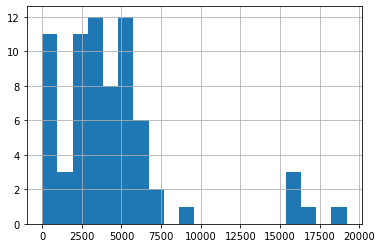

In [203]:
lib10_cnt[(lib10_cnt.ShortName == 'SL1344_0033') & (lib10_cnt.day == 'd0')].cnt.hist(bins=20)

In [198]:
x = final[['d1_fitness_mean', 'num_barcodes']].drop_duplicates()
x[x.num_barcodes>1].sort_values('num_barcodes')

d1_fitness_mean  num_barcodes
gene                                            
CACCCGCTCACTGAATC        -0.080943           2.0
envR                     -0.087606           2.0
feoB                      0.580616           2.0
fimA                      0.385861           2.0
fimW                     -0.365108           2.0
...                            ...           ...
SL1344_4434               0.005161           8.0
SL1344_3564               0.261066           8.0
pilV                     -0.189067           9.0
SL1344_0033               0.029013          10.0
siiE                      0.302800          35.0

[300 rows x 2 columns]

In [366]:
compare

index  method2_padj  method2_padj_ci  method2_fitness  \
0     AAAAACATGCCACACTG      0.500978         0.986260         1.734346   
1     AAAACTTCATGTACAGA      0.225623         0.948679         1.960143   
2     AAACGGCCGAGTTCGAG      0.758487         0.197858         0.806160   
3     AAACGTCCCCACACGGG      0.207034         0.948679         1.383929   
4     AAAGAAGCTATAAACTA      0.584842         0.933628         2.155005   
...                 ...           ...              ...              ...   
1173               ysaA      0.215091         0.719870         4.533653   
1174               ytfF      0.887229         0.453745         1.107771   
1175               ytfG      0.834566         0.471363         1.109892   
1176               ytfJ      0.986260         0.314128         1.635816   
1177               ytfM      0.000749         0.001508         0.483930   

      method2_ci  method2_hits  method2_ci_hits  method1_fitness  method1_ci  \
0       1.323248         False            False         0.801205    1.030174   
1       2.140346         False            False         1.025133    1.203149   
2       0.905080         False            False        -0.319444    0.473764   
3       1.526946         False            False         0.492743    0.831868   
4       2.264930         False            False         1.156746    1.318072   
...          ...           ...              ...              ...         ...   
1173    2.566085         False            False         0.559329    0.871162   
1174    1.311087         False            False         0.157595    0.659424   
1175    1.162841         False            False         0.149174    0.655586   
1176    1.935724         False            False         0.745651    0.991259   
1177    0.537432          True             True        -0.782719    0.343638   

      method1_zscore  method1_padj  method1_hits  
0           0.070289      0.963545         False  
1           0.354649      0.836130         False  
2          -1.836118      0.405389         False  
3          -0.490198      0.768527         False  
4           0.567885      0.737707         False  
...              ...           ...           ...  
1173       -0.318469      0.848565         False  
1174       -0.896856      0.589708         False  
1175       -0.787841      0.635953         False  
1176       -0.015857      0.992454         False  
1177       -1.864740      0.392937         False  

[1178 rows x 12 columns]

In [381]:
fig = px.scatter(compare, x='method1_zscore', y=compare['method2_ci'],hover_data=['index'], log_y=True,
             template='simple_white', color='method2_ci_hits', symbol='method1_hits',
          labels={'method1_fitness': 'log2FC as calculated by DESeq',
                 'method1_zscore': 'Method 1 Z-Score',
                  'method2_hits': 'Method 2 padj < 0.05',
                  'method1_hits': 'Method 1 padj < 0.05',
                 'index': 'gene'}, trendline='ols')


fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

In [164]:
fig = px.scatter(compare, x='method1_fitness', y=np.log2(compare.method2_fitness),hover_data=['index'], 
           color='method2_hits', symbol = 'method1_hits', template='simple_white', 
          labels={'method1_fitness': 'log2FC as calculated by DESeq',
                 'y': 'log2(Method 2 Fitness)',
                  'method2_hits': 'Method 2 padj < 0.05',
                  'method1_hits': 'Method 1 padj < 0.05',
                 'index': 'gene'})


fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

In [133]:
compare.method2_ci_hits.sum()

104

In [155]:
fig = px.density_heatmap(compare, x='method1_ci',y='method2_ci')
fig

In [385]:
fig = px.scatter(compare, x='method1_ci', y='method2_ci', color='method2_ci_hits', 
                 log_x=True, log_y=True, hover_data=['index'], 
                template='simple_white', 
                labels={'method1_ci': 'Method 1 CI', 'method2_ci': 'Method 2 CI', 
                       'method2_ci_hits': 'Method 2 CI padj < 0.05', 'index': 'gene'})
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig

In [10]:
vst_fit_d1.sample(10)

ad926_d1_dnaid2017_TV4592A  ad927_d1_dnaid2017_TV4592A  \
ShortName                                                                   
menD                                 1.000842                    0.987673   
TTTGTTACACGACCTAC                    1.288966                    0.290832   
CCGTGTCCTTTGTAATT                    1.341455                    0.315676   
wcaC                                 1.151381                    0.236522   
otsA                                 1.232451                    1.103374   
CCTGCTACTAAAGAATT                    1.351382                    1.018033   
IsrB-1                               1.255899                    0.441996   
traL                                 0.635167                    0.970705   
lpxO                                 0.908577                    0.908577   
CGAACGGGCGCCATATA                    1.088406                    1.069602   

                   ad928_d1_dnaid2017_TV4592A  ad929_d1_dnaid2017_TV4592A  \
ShortName                                                                   
menD                                 1.095857                    1.351637   
TTTGTTACACGACCTAC                    0.777017                    1.106293   
CCGTGTCCTTTGTAATT                    1.098150                    1.290504   
wcaC                                 1.122715                    1.127377   
otsA                                 0.934887                    1.297863   
CCTGCTACTAAAGAATT                    0.902099                    0.905916   
IsrB-1                               0.971004                    0.891807   
traL                                 0.891721                    0.862640   
lpxO                                 0.908577                    0.908577   
CGAACGGGCGCCATATA                    1.100952                    1.558433   

                   ad930_d1_dnaid2017_TV4592A  am483_d1_dnaid2027_TV5563A  \
ShortName                                                                   
menD                                 0.976029                    1.163969   
TTTGTTACACGACCTAC                    0.958350                    1.038569   
CCGTGTCCTTTGTAATT                    1.138710                    1.267338   
wcaC                                 1.063552                    1.493564   
otsA                                 1.167522                    0.934887   
CCTGCTACTAAAGAATT                    0.981000                    1.523501   
IsrB-1                               1.071202                    0.755949   
traL                                 0.782690                    0.498173   
lpxO                                 0.908577                    1.746039   
CGAACGGGCGCCATATA                    1.074418                    0.785183   

                   am484_d1_dnaid2027_TV5563A  am485_d1_dnaid2027_TV5563A  \
ShortName                                                                   
menD                                 0.781550                    0.781550   
TTTGTTACACGACCTAC                    0.817394                    0.205036   
CCGTGTCCTTTGTAATT                    1.014298                    1.218772   
wcaC                                 1.790840                    0.321896   
otsA                                 0.934887                    0.934887   
CCTGCTACTAAAGAATT                    1.577397                    0.689857   
IsrB-1                               0.674984                    0.597626   
traL                                 0.773693                    0.220854   
lpxO                                 2.363027                    1.357004   
CGAACGGGCGCCATATA                    1.038735                    0.785183   

                   am486_d1_dnaid2027_TV5563A  am487_d1_dnaid2027_TV5563A  \
ShortName                                                                   
menD                                 0.781550                    0.781550   
TTTGTTACACGACCTAC                    0.686285                    0.121862   
CCGTGTCCTTT

In [141]:
vst_d1_results

pval      padj   ci_pval   ci_padj  median_fitness  \
ShortName                                                                   
AAAAACATGCCACACTG  0.293476  0.500978  0.986260  0.986260        1.119034   
AAAACGCAGCGCTTGCC  0.398744  0.600342  0.769698  0.933327        1.264869   
AAAACTTCATGTACAGA  0.065369  0.225623  0.876825  0.948679        1.104863   
AAAATTCTTTCTCCCCG  0.018305  0.111847  0.593428  0.852658        1.000000   
AAACAATAGGGGGGTAG  0.418272  0.615508  0.262963  0.564817        0.993225   
...                     ...       ...       ...       ...             ...   
ytfF               0.822848  0.887229  0.184815  0.453745        0.962732   
ytfG               0.743506  0.834566  0.196484  0.471363        0.975542   
ytfJ               0.986260  0.986260  0.101825  0.314128        0.882163   
ytfM               0.000021  0.000749  0.000045  0.001508        0.556929   
zwf                0.034152  0.159600  0.876825  0.948679        0.962611   

                   mean_fitness  median_CI   mean_CI   hits  ci_hits  
ShortName                                                             
AAAAACATGCCACACTG      1.734346   1.194449  1.323248  False    False  
AAAACGCAGCGCTTGCC      1.510653   1.406138  1.277696  False    False  
AAAACTTCATGTACAGA      1.960143   1.139164  2.140346  False    False  
AAAATTCTTTCTCCCCG      1.037107   1.135089  1.109729  False    False  
AAACAATAGGGGGGTAG      0.967098   1.069282  1.055919  False    False  
...                         ...        ...       ...    ...      ...  
ytfF                   1.107771   1.082354  1.311087  False    False  
ytfG                   1.109892   0.980866  1.162841  False    False  
ytfJ                   1.635816   0.920774  1.935724  False    False  
ytfM                   0.483930   0.530223  0.537432   True     True  
zwf                    1.310437   1.184840  1.184631  False    False  

[1888 rows x 10 columns]

# Analysis

In [365]:
vst_fit_d1.head()

ad926_d1_dnaid2017_TV4592A  ad927_d1_dnaid2017_TV4592A  \
ShortName                                                                   
AAAAACATGCCACACTG                    1.119034                    0.268403   
AAAACGCAGCGCTTGCC                    1.898760                    1.316736   
AAAACTTCATGTACAGA                    0.938151                    0.133599   
AAAATTCTTTCTCCCCG                    1.000000                    1.000000   
AAACAATAGGGGGGTAG                    1.007408                    0.995898   

                   ad928_d1_dnaid2017_TV4592A  ad929_d1_dnaid2017_TV4592A  \
ShortName                                                                   
AAAAACATGCCACACTG                    0.800264                    0.939477   
AAAACGCAGCGCTTGCC                    1.602933                    1.981184   
AAAACTTCATGTACAGA                    1.290833                    1.698864   
AAAATTCTTTCTCCCCG                    1.198761                    1.261729   
AAACAATAGGGGGGTAG                    1.015054                    0.813069   

                   ad930_d1_dnaid2017_TV4592A  am483_d1_dnaid2027_TV5563A  \
ShortName                                                                   
AAAAACATGCCACACTG                    0.974508                    1.565607   
AAAACGCAGCGCTTGCC                    1.363800                    1.359144   
AAAACTTCATGTACAGA                    1.104863                    1.534568   
AAAATTCTTTCTCCCCG                    1.170335                    1.000000   
AAACAATAGGGGGGTAG                    0.951563                    0.993225   

                   am484_d1_dnaid2027_TV5563A  am485_d1_dnaid2027_TV5563A  \
ShortName                                                                   
AAAAACATGCCACACTG                    1.616719                    0.705720   
AAAACGCAGCGCTTGCC                    1.400544                    0.804508   
AAAACTTCATGTACAGA                    1.560387                    0.291833   
AAAATTCTTTCTCCCCG                    1.000000                    1.000000   
AAACAATAGGGGGGTAG                    1.111467                    1.272304   

                   am486_d1_dnaid2027_TV5563A  am487_d1_dnaid2027_TV5563A  \
ShortName                                                                   
AAAAACATGCCACACTG                    1.196386                    0.268935   
AAAACGCAGCGCTTGCC                    1.264869                    6.852321   
AAAACTTCATGTACAGA                    0.941041                    3.429486   
AAAATTCTTTCTCCCCG                    1.000000                    1.000000   
AAACAATAGGGGGGTAG                    0.813069                    0.813069   

                   am488_d1_dnaid2027_TV5563A  am727_d1_dnaid2028_TV5585A  \
ShortName                                                                   
AAAAACATGCCACACTG                    1.479617                    1.193834   
AAAACGCAGCGCTTGCC                    1.009249                    0.804508   
AAAACTTCATGTACAGA                    1.007121                    1.074207   
AAAATTCTTTCTCCCCG                    1.000000                    1.000000   
AAACAATAGGGGGGTAG                    1.162318                    0.813069   

                   am728_d1_dnaid2028_TV5585A  am729_d1_dnaid2028_TV5585A  \
ShortName                                                                   
AAAAACATGCCACACTG                    1.505992                    1.042335   
AAAACGCAGCGCTTGCC                    0.804508                    0.804508   
AAAACTTCATGTACAGA                    1.653094                    1.089463   
AAAATTCTTTCTCCCCG                    1.000000                    1.000000   
AAACAATAGGGGGGTAG                    1.004926                    0.948784   

                   am730_d1_dnaid2028_TV5585A  am731_d1_dnaid2028_TV5585A  \
ShortName                                                                   
AAAAACATGCCACACTG                    0.153358                    1.652140   
AAAACGCA

In [297]:

days = ['_d1', '_d2', '_d3', '_d4']

fitness_dfs = []
ci_dfs = []
results_dfs = []
wt_fitness = []
ssa_ci = []
ci_notmelted = []
for day in days:
    print(day)
    vst_fit, vst_ci, results, vst_controls, vst_ssa_ci = get_fitness(vst, annotation_df, day, 
                                                                        good_samples=good_samples,  hits=0.05)
      
    df = vst_fit.reset_index().melt( id_vars = ['ShortName'], var_name='sampleID', value_name='Fitness')    
    #df['sampleID'] = df['sampleID'].str.replace(day, '')
    df['day'] = day.strip('_')
    
    fitness_dfs.append(df)
    
    ci_notmelted.append(vst_ci)
    df2 = vst_ci.reset_index().melt(id_vars = ['ShortName'], var_name='sampleID', value_name='CI')    
    #df2['sampleID'] = df2['sampleID'].str.replace(day, '')
    df2['day'] = day.strip('_')
    
    ci_dfs.append(df2)
    
    results['day'] = day.strip("_")
    results_dfs.append(results)

    wt_fitness.append(vst_controls)
    ssa_ci.append(vst_ssa_ci)

fitness_df = pd.concat(fitness_dfs)
ci_df = pd.concat(ci_dfs)
results_df = pd.concat(results_dfs)
wt_fitness_df = pd.concat(wt_fitness)
ssa_ci_df = pd.concat(ssa_ci)


_d1
_d2
_d3
_d4


In [269]:
days = ['_d1', '_d2', '_d3', '_d4']

rare_fitness_dfs = []
rare_ci_dfs = []
rare_results_dfs = []
rare_wt_fitness = []
rare_ssa_ci = []

for day in days:
    print(day)
    vst_fit, vst_ci, results, vst_controls, vst_ssa_ci = get_fitness(rare, annotation_df, 'd1', good_samples=samples, rare=True,  hits=0.05)
      
    df = vst_fit.reset_index().melt( id_vars = ['ShortName'], var_name='sampleID', value_name='Fitness')    
    #df['sampleID'] = df['sampleID'].str.replace(day, '')
    df['day'] = day.strip('_')
    
    fitness_dfs.append(df)
    
    
    df2 = vst_ci.reset_index().melt(id_vars = ['ShortName'], var_name='sampleID', value_name='CI')    
    #df2['sampleID'] = df2['sampleID'].str.replace(day, '')
    df2['day'] = day.strip('_')
    
    ci_dfs.append(df2)
    
    results['day'] = day.strip("_")
    results_dfs.append(results)

    wt_fitness.append(vst_controls)
    ssa_ci.append(vst_ssa_ci)

rare_fitness_df = pd.concat(fitness_dfs)
rare_ci_df = pd.concat(ci_dfs)
rare_results_df = pd.concat(results_dfs)
rare_wt_fitness_df = pd.concat(wt_fitness)
rare_ssa_ci_df = pd.concat(ssa_ci)

_d1
_d2
_d3
_d4


In [171]:
fitness_df.to_csv(Path("/Users/ansintsova/git_repos/nguyenb_tnseq/data/28_05_results")/"library_10_2.fitness.csv")
ci_df.to_csv(Path("/Users/ansintsova/git_repos/nguyenb_tnseq/data/28_05_results")/"library_10_2.ci.csv")
wt_fitness_df.to_csv(Path("/Users/ansintsova/git_repos/nguyenb_tnseq/data/28_05_results")/"library_10_2.wt_fitness.csv")
ssa_ci_df.to_csv(Path("/Users/ansintsova/git_repos/nguyenb_tnseq/data/28_05_results")/"library_10_2.ssa_ci.csv")

In [190]:
results_df = results_df.reset_index()
rare_results_df = rare_results_df.reset_index()

In [185]:
deseq1

ShortName  log2FoldChange   fitness
0     AAAAACATGCCACACTG        0.874040  1.832788
1     AAAACGCAGCGCTTGCC       -0.196088  0.872914
2     AAAACTTCATGTACAGA        1.049991  2.070518
3     AAAATTCTTTCTCCCCG       -1.683521  0.311322
4     AAACAATAGGGGGGTAG        0.208786  1.155715
...                 ...             ...       ...
1883               ytfF        0.212746  1.158892
1884               ytfG        0.181758  1.134265
1885               ytfJ        0.762432  1.696348
1886               ytfM       -1.236930  0.424275
1887                zwf       -0.783809  0.580831

[1888 rows x 3 columns]

In [455]:
rd1 = results_df[results_df.day == 'd1'].merge(rare_results_df[rare_results_df.day == 'd1'], on='ShortName').merge(deseq1, on='ShortName')
rd1 = rd1.merge(vst_inoculum_cnts, on='ShortName')
rd1['median_inoculum'] = 2**rd1['median_inoculum_value']
rd1.columns= [c.replace('_x', '_vst').replace("_y", '_rare') for c in rd1.columns]
rd1['deseq_hit'] = rd1.ShortName.apply(lambda x: True if x in deseqhits else False)
rd1['rareDeseq'] = rd1['deseq_hit'].astype(int)*3 + rd1['hits_rare'].astype(int)
rd1['rareDeseq'] = rd1['rareDeseq'].replace({0: 'Not a hit', 1: 'RARE hit', 3: 'DESEQ hit', 4: 'DESEQ and RARE hit'})
rd1['vstDeseq'] = rd1['deseq_hit'].astype(int)*3 + rd1['hits_vst'].astype(int)
rd1['vstDeseq'] = rd1['vstDeseq'].replace({0: 'Not a hit', 1: 'VST hit', 3: 'DESEQ hit', 4: 'DESEQ and VST hit'})
fig6 = px.scatter(x=rd1.median_fitness_rare, template="simple_white",
                 labels = {'x': 'Median Fitness','y':'log2FoldChange'},
           y=rd1.log2FoldChange, color=rd1.rareDeseq,  hover_data=[rd1.ShortName], )
#fig.update_xaxes(range=[-10, 5])
fig6

In [456]:
fig5 = px.scatter(x=rd1.median_fitness_vst, 
           y=rd1.log2FoldChange, color=rd1.vstDeseq,  hover_data=[rd1.ShortName], template='simple_white',
                labels = {'x': 'Median Fitness','y':'log2FoldChange'},)
#fig.update_xaxes(range=[-10, 5])
fig5

In [384]:
rd1.head()

ShortName  pval_vst  padj_vst  ci_pval_vst  ci_padj_vst  \
0  AAAAACATGCCACACTG  0.293476  0.500978     0.986260     0.986260   
1  AAAAACATGCCACACTG  0.293476  0.500978     0.986260     0.986260   
2  AAAACGCAGCGCTTGCC  0.398744  0.600342     0.769698     0.933327   
3  AAAACGCAGCGCTTGCC  0.398744  0.600342     0.769698     0.933327   
4  AAAACTTCATGTACAGA  0.065369  0.225623     0.876825     0.948679   

   median_fitness_vst  mean_fitness_vst  median_CI_vst  mean_CI_vst  hits_vst  \
0            1.119034          1.734346       1.194449     1.323248     False   
1            1.119034          1.734346       1.194449     1.323248     False   
2            1.264869          1.510653       1.406138     1.277696     False   
3            1.264869          1.510653       1.406138     1.277696     False   
4            1.104863          1.960143       1.139164     2.140346     False   

   ...  mean_CI_rare hits_rare  ci_hits_rare  day_rare  log2FoldChange  \
0  ...      1.323248     False         False        d1        0.874040   
1  ...      1.402141     False         False        d1        0.874040   
2  ...      1.277696     False         False        d1       -0.196088   
3  ...      2.493900     False         False        d1       -0.196088   
4  ...      2.140346     False         False        d1        1.049991   

    fitness  median_inoculum_value  deseq_hit  rareDeseq   vstDeseq  
0  1.832788              11.716504      False  Not a hit  Not a hit  
1  1.832788              11.716504      False  Not a hit  Not a hit  
2  0.872914               5.175039      False  Not a hit  Not a hit  
3  0.872914               5.175039      False  Not a hit  Not a hit  
4  2.070518              10.791493      False  Not a hit  Not a hit  

[5 rows x 29 columns]

In [451]:
fig1 = px.scatter(rd1, x='median_fitness_vst', y='padj_vst', color='hits_vst',
                color_discrete_map={True: px.colors.qualitative.Plotly[1], False:px.colors.qualitative.Plotly[0]}, size='median_inoculum',
                  labels= {'median_fitness_vst': 'Median Fitness', 'padj_vst': 'Adjusted p-value',
                           'hits_vst': 'Adjusted p-vaue < 0.05'},
                  template = 'simple_white',
                  title = 'Fitness (VST Data)',
                      log_y=True,  hover_data={'gene':rd1.ShortName})
fig1.update_yaxes(autorange="reversed")


fig1.show()

In [452]:
fig2 = px.scatter(rd1, x='median_fitness_rare', y='padj_rare', color='hits_rare',
                color_discrete_map={True: px.colors.qualitative.Plotly[1], False:px.colors.qualitative.Plotly[0]}, size='median_inoculum',
                  labels= {'median_fitness_rare': 'Median Fitness', 'padj_rare': 'Adjusted p-value',
                           'hits_rare': 'Adjusted p-vaue < 0.05'},
                  template = 'simple_white',
                  title = 'Fitness (Rarefied Data)',
                      log_y=True,  hover_data={'gene':rd1.ShortName})
fig2.update_yaxes(autorange="reversed")
fig2.show()

In [394]:
rd1.head()

ShortName  pval_vst  padj_vst  ci_pval_vst  ci_padj_vst  \
0  AAAAACATGCCACACTG  0.293476  0.500978     0.986260     0.986260   
1  AAAAACATGCCACACTG  0.293476  0.500978     0.986260     0.986260   
2  AAAACGCAGCGCTTGCC  0.398744  0.600342     0.769698     0.933327   
3  AAAACGCAGCGCTTGCC  0.398744  0.600342     0.769698     0.933327   
4  AAAACTTCATGTACAGA  0.065369  0.225623     0.876825     0.948679   

   median_fitness_vst  mean_fitness_vst  median_CI_vst  mean_CI_vst  hits_vst  \
0            1.119034          1.734346       1.194449     1.323248     False   
1            1.119034          1.734346       1.194449     1.323248     False   
2            1.264869          1.510653       1.406138     1.277696     False   
3            1.264869          1.510653       1.406138     1.277696     False   
4            1.104863          1.960143       1.139164     2.140346     False   

   ...  hits_rare ci_hits_rare  day_rare  log2FoldChange   fitness  \
0  ...      False        False        d1        0.874040  1.832788   
1  ...      False        False        d1        0.874040  1.832788   
2  ...      False        False        d1       -0.196088  0.872914   
3  ...      False        False        d1       -0.196088  0.872914   
4  ...      False        False        d1        1.049991  2.070518   

   median_inoculum_value  median_inoculum  deseq_hit  rareDeseq   vstDeseq  
0              11.716504      3365.263845      False  Not a hit  Not a hit  
1              11.716504      3365.263845      False  Not a hit  Not a hit  
2               5.175039        36.127846      False  Not a hit  Not a hit  
3               5.175039        36.127846      False  Not a hit  Not a hit  
4              10.791493      1772.405536      False  Not a hit  Not a hit  

[5 rows x 30 columns]

In [453]:
fig3 = px.scatter(rd1, x='median_CI_rare', y='ci_padj_rare', color='ci_hits_rare',
                color_discrete_map={True: px.colors.qualitative.D3[1], False:px.colors.qualitative.D3[0]}, size='median_inoculum',
                  labels= {'median_CI_rare': 'Median CI', 'ci_padj_rare': 'Adjusted p-value',
                           'ci_hits_rare': 'Adjusted p-vaue < 0.05'},
                  title = 'Comptetive Indices (Rarefied Data)',
                  template = 'simple_white',
                      log_y=True,  hover_data={'gene':rd1.ShortName})
fig3.update_yaxes(autorange="reversed")
fig3.show()

In [413]:
((rd1['ci_hits_vst'].astype(int)+rd1['ci_hits_rare'].astype(int))==2).sum()

311

In [414]:
311/rd1['ci_hits_vst'].sum()

0.7933673469387755

In [454]:
fig4 = px.scatter(rd1, x='median_CI_vst', y='ci_padj_vst', color='ci_hits_vst',
                color_discrete_map={True: px.colors.qualitative.D3[1], False:px.colors.qualitative.D3[0]}, size='median_inoculum',
                  labels= {'median_CI_vst': 'Median CI', 'ci_padj_vst': 'Adjusted p-value',
                           'ci_hits_vst': 'Adjusted p-vaue < 0.05'},
                  template = 'simple_white',
                  title = 'Comptetive Indices (VST Data)',
                      log_y=True,  hover_data={'gene':rd1.ShortName})
fig4.update_yaxes(autorange="reversed")
fig4.show()

In [457]:
with open('/Users/ansintsova/Documents/SushiLab/31-05-2021-Lab-Meeting/volcanos.html', 'a') as f:
    f.write(fig1.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig2.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig3.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig4.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig5.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig6.to_html(full_html=False, include_plotlyjs='cdn'))

## Visualize Fitness Results : Day 1

### VST


In [144]:
fig = px.scatter(vst_fit_d1, x='median_fitness', y='padj',color='hits', size='median_inoculum_value', 
                 log_y=True, log_x=True, hover_data=[vst_fit_d1.index, vst_fit_d1.median_inoculum_value], 
                color_discrete_sequence=['blue', "red"],)
fig.update_yaxes(autorange="reversed")
fig.show()

In [145]:
fig = px.scatter(rare_fit_d1, x='median_fitness', y='padj',color='hits', size='median_inoculum_value', 
                 log_y=True, log_x=True, hover_data=[rare_fit_d1.index, rare_fit_d1.median_inoculum_value], 
                color_discrete_sequence=["red", "blue"])
fig.update_yaxes(autorange="reversed")
fig.show()

## Visualize CI Results :

### VST

In [146]:
fig = px.scatter(vst_ci_d1, x='median_CI', y='ci_padj',color='hits', 
                 log_y=True, log_x=True, hover_data=[vst_ci_d1.index], 
                color_discrete_sequence=['blue', "red"],)
fig.update_yaxes(autorange="reversed")
fig.show()

### Rarefied

In [147]:
fig = px.scatter(rare_ci_d1, x='median_CI', y='ci_padj',color='hits', 
                 log_y=True, log_x=True, hover_data=[rare_ci_d1.index], 
                color_discrete_sequence=['blue', "red"],)
fig.update_yaxes(autorange="reversed")
fig.show()

### Visualize Fitness Results : Day 2
## VST

In [ ]:
fig = px.scatter(vst_fit_d1, x='median_fitness', y='padj',color='hits', size='median_inoculum_value', 
                 log_y=True, log_x=True, hover_data=[vst_fit_d1.index, vst_fit_d1.median_inoculum_value], 
                color_discrete_sequence=['blue', "red"],)
fig.update_yaxes(autorange="reversed")
fig.show()

ShortName      pval      padj   ci_pval   ci_padj  median_fitness  \
0  AAAAACATGCCACACTG  0.293476  0.500978  0.986260  0.986260        1.119034   
1  AAAACGCAGCGCTTGCC  0.398744  0.600342  0.769698  0.933327        1.264869   
2  AAAACTTCATGTACAGA  0.065369  0.225623  0.876825  0.948679        1.104863   
3  AAAATTCTTTCTCCCCG  0.018305  0.111847  0.593428  0.852658        1.000000   
4  AAACAATAGGGGGGTAG  0.418272  0.615508  0.262963  0.564817        0.993225   

   mean_fitness  median_CI   mean_CI   hits  ci_hits day  
0      1.734346   1.194449  1.323248  False    False  d1  
1      1.510653   1.406138  1.277696  False    False  d1  
2      1.960143   1.139164  2.140346  False    False  d1  
3      1.037107   1.135089  1.109729  False    False  d1  
4      0.967098   1.069282  1.055919  False    False  d1

In [279]:
sample_info = ci_df.sampleID.str.split("_", expand=True)
sample_info.columns = ['mouse', 'dnaid', 'experiment']

In [298]:
ci= ci_df.merge(sample_info, left_index=True, right_index=True)

In [282]:
ci.sample(5)

ShortName                 sampleID        CI day  mouse  \
1867                yneA  ad926_dnaid2018_TV4592A  3.276698  d3  ad926   
14821               stbA  am488_dnaid2027_TV5563A  1.164287  d2  am727   
16609               rhaS  am486_dnaid2027_TV5563A  2.054812  d1  am732   
9870   GCGCCTGAAATGACCCC  am486_dnaid2027_TV5563A  1.677733  d3  am483   
6251         SL1344_0707  ad929_dnaid2018_TV4592A  0.888710  d4  ad929   

           dnaid experiment  
1867   dnaid2018    TV4592A  
14821  dnaid2029    TV5585A  
16609  dnaid2029    TV5585A  
9870   dnaid2027    TV5563A  
6251   dnaid2018    TV4592A

In [283]:
?ci.pivot

In [323]:
sdf = ci[['sampleID', 'mouse', 'day', 'dnaid', 'experiment']].drop_duplicates().set_index('sampleID')
sdf

mouse day      dnaid experiment
sampleID                                                   
ad926_d1_dnaid2017_TV4592A  ad926  d1  dnaid2017    TV4592A
ad926_d1_dnaid2017_TV4592A  ad926  d1  dnaid2018    TV4592A
ad926_d2_dnaid2017_TV4592A  ad926  d2  dnaid2017    TV4592A
ad926_d2_dnaid2017_TV4592A  ad926  d2  dnaid2018    TV4592A
ad926_d3_dnaid2018_TV4592A  ad926  d3  dnaid2017    TV4592A
...                           ...  ..        ...        ...
am732_d2_dnaid2028_TV5585A  am729  d2  dnaid2028    TV5585A
am732_d2_dnaid2028_TV5585A  am732  d2  dnaid2028    TV5585A
am730_d1_dnaid2028_TV5585A  am730  d1  dnaid2028    TV5585A
am731_d1_dnaid2028_TV5585A  am731  d1  dnaid2028    TV5585A
am732_d1_dnaid2028_TV5585A  am732  d1  dnaid2028    TV5585A

[134 rows x 4 columns]

In [290]:
edf = pd.concat(ci_notmelted, axis=1)

In [300]:
edf.head()

ad926_d1_dnaid2017_TV4592A  ad927_d1_dnaid2017_TV4592A  \
ShortName                                                                   
AAAAACATGCCACACTG                    1.194449                    0.429856   
AAAACGCAGCGCTTGCC                    2.026722                    2.108795   
AAAACTTCATGTACAGA                    1.001375                    0.213963   
AAAATTCTTTCTCCCCG                    1.067393                    1.601532   
AAACAATAGGGGGGTAG                    1.075300                    1.594962   

                   ad928_d1_dnaid2017_TV4592A  ad929_d1_dnaid2017_TV4592A  \
ShortName                                                                   
AAAAACATGCCACACTG                    0.702334                    0.894640   
AAAACGCAGCGCTTGCC                    1.406777                    1.886631   
AAAACTTCATGTACAGA                    1.132870                    1.617785   
AAAATTCTTTCTCCCCG                    1.052065                    1.201512   
AAACAATAGGGGGGTAG                    0.890839                    0.774265   

                   ad930_d1_dnaid2017_TV4592A  am483_d1_dnaid2027_TV5563A  \
ShortName                                                                   
AAAAACATGCCACACTG                    1.004761                    1.760138   
AAAACGCAGCGCTTGCC                    1.406138                    1.528022   
AAAACTTCATGTACAGA                    1.139164                    1.725243   
AAAATTCTTTCTCCCCG                    1.206668                    1.124253   
AAACAATAGGGGGGTAG                    0.981104                    1.116637   

                   am484_d1_dnaid2027_TV5563A  am485_d1_dnaid2027_TV5563A  \
ShortName                                                                   
AAAAACATGCCACACTG                    1.628047                    0.868643   
AAAACGCAGCGCTTGCC                    1.410358                    0.990238   
AAAACTTCATGTACAGA                    1.571321                    0.359205   
AAAATTCTTTCTCCCCG                    1.007007                    1.230860   
AAACAATAGGGGGGTAG                    1.119255                    1.566028   

                   am486_d1_dnaid2027_TV5563A  am487_d1_dnaid2027_TV5563A  \
ShortName                                                                   
AAAAACATGCCACACTG                    1.358004                    0.029121   
AAAACGCAGCGCTTGCC                    1.435739                    0.741978   
AAAACTTCATGTACAGA                    1.068165                    0.371349   
AAAATTCTTTCTCCCCG                    1.135089                    0.108281   
AAACAATAGGGGGGTAG                    0.922906                    0.088040   

                   ...  am732_d3_dnaid2029_TV5585A  \
ShortName          ...                               
AAAAACATGCCACACTG  ...                    4.964193   
AAAACGCAGCGCTTGCC  ...                    2.905918   
AAAACTTCATGTACAGA  ...                    7.605537   
AAAATTCTTTCTCCCCG  ...                    3.612042   
AAACAATAGGGGGGTAG  ...                    5.283497   

                   ad926_d4_dnaid2018_TV4592A  ad927_d4_dnaid2018_TV4592A  \
ShortName                                                                   
AAAAACATGCCACACTG                    2.154754                    0.629682   
AAAACGCAGCGCTTGCC                    1.207906                    1.505861   
AAAACTTCATGTACAGA                    1.382148                    0.282449   
AAAATTCTTTCTCCCCG                    1.501421                    1.871778   
AAACAATAGGGGGGTAG                    1.685226                    2.269620   

                   ad928_d4_dnaid2018_TV4592A  ad929_d4_dnaid2018_TV4592A  \
ShortName                                                                   
AAAAACATGCCACACTG                    1.257524                    1.526160   
AAAACGCAGCGCTTGCC                    1.239921                    1.538732   
AAAACTTCATGTACAGA                    1.478894                    3.204074   
AAAATTCTTTCTCCC

In [317]:
#import skmisc
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA

"""
Plotting PCA elipses:
__author__:
"""

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).
    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)


def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip
#____________________________________________________




def plotPCA(pDf, pc1_var, pc2_var, colorby, col, nameby="", el=False):
    sns.set_style("ticks")
    sns.set_context("notebook", font_scale=2.2)
    group = pDf[colorby].unique()
    assert len(group) <= len(col)
    fig = plt.figure(figsize=(8, 8))
    for g, c in zip(group, col):
        df = pDf[pDf[colorby] == g]
        x, y = df[["PC1"]].values, df[["PC2"]].values
        ax = plt.scatter(x, y, c=c, s=150, label=g)
        if el:
            pts = np.asarray([[float(a), float(b)] for a, b in zip(x, y)])
            plot_point_cov(pts, nstd=2, alpha=0.1, color=c)
        if nameby:
            labels = df[nameby]
            for label, pc1, pc2 in zip(labels, x, y):
                plt.annotate(label, xy=(pc1, pc2), xytext=(-5, 7), textcoords="offset points",fontsize=14)
        plt.xlabel('Principal Component 1, {} %'.format(pc1_var), )
        plt.ylabel('Principal Component 2, {} %'.format(pc2_var), )
        #plt.xticks(fontsize=16)
        #plt.yticks(fontsize=16)
        plt.legend(frameon=True)
    return fig

def find_pc1_pc2(df, meta):
    df = df.T
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df)
    
    pDf = (pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
           .set_index(df.index))
    pc1_var = round(pca.explained_variance_ratio_[0] * 100, 2)
    pc2_var = round(pca.explained_variance_ratio_[1] * 100, 2)
    pDf2 = pDf.merge(meta, left_index=True, right_index=True)
    return pDf2, pc1_var, pc2_var

In [324]:
pDf, pc1, pc2 = find_pc1_pc2(edf, sdf)

In [319]:
pDf

PC1          PC2 day      dnaid experiment
ad926_d1_dnaid2017_TV4592A  -181.778745   -76.323632  d1  dnaid2017    TV4592A
ad926_d1_dnaid2017_TV4592A  -181.778745   -76.323632  d1  dnaid2018    TV4592A
ad926_d2_dnaid2017_TV4592A  -180.633864   -74.763500  d2  dnaid2017    TV4592A
ad926_d2_dnaid2017_TV4592A  -180.633864   -74.763500  d2  dnaid2018    TV4592A
ad926_d3_dnaid2018_TV4592A  -175.263292   -71.094617  d3  dnaid2017    TV4592A
...                                 ...          ...  ..        ...        ...
am732_d3_dnaid2029_TV5585A  1209.687807  2365.145987  d3  dnaid2028    TV5585A
am732_d3_dnaid2029_TV5585A  1209.687807  2365.145987  d3  dnaid2029    TV5585A
am732_d4_dnaid2029_TV5585A  6315.182600  -900.319320  d4  dnaid2027    TV5563A
am732_d4_dnaid2029_TV5585A  6315.182600  -900.319320  d4  dnaid2028    TV5585A
am732_d4_dnaid2029_TV5585A  6315.182600  -900.319320  d4  dnaid2029    TV5585A

[103 rows x 5 columns]

In [459]:
pca = px.scatter(pDf, x='PC1', y='PC2', color='mouse', symbol='day', 
          color_discrete_sequence= px.colors.qualitative.Dark24, 
                hover_data=[pDf.experiment], )


pca.update_traces(marker=dict(size=14,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers')
                 )

In [460]:
pca.write_html("/Users/ansintsova/Documents/SushiLab/31-05-2021-Lab-Meeting/PCA.html")

In [340]:
sdf = pd.Series(fdf.columns).str.split('_', expand = True)
sdf.columns = ['mouse', 'day', 'dnaid', 'experiment']
sdf = pd.DataFrame(fdf.columns).merge(sdf, left_index=True, right_index=True).set_index(0)

In [342]:
pDf, pc1, pc2 = find_pc1_pc2(fdf, sdf)

In [352]:
?px.scatter